In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import json
import cvxpy as cp
from collections import defaultdict, Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
def sample_utility(m, n, sample_m,sample_n,W):
    rng = np.random.default_rng()

    users = rng.choice(m, size=sample_m, replace=False)
    items = rng.choice(n, size=sample_n, replace=False)
    return W[users][:,items]

def sample_candidate_items(rel_matrix_users: np.ndarray, n_candidates: int) -> np.ndarray:
    top_items = np.argsort(rel_matrix_users, axis=1)[:, -n_candidates:]
    unique_items = np.unique(top_items)
    return rel_matrix_users[np.arange(rel_matrix_users.shape[0])[:, None], unique_items]

def sample_users_from_groups(users_count: int, items_count: int, groups_map: dict[int, str], group_name: str, data: np.ndarray, naive_sampling: bool = True) -> tuple[np.ndarray, list[int]]:
    users_per_group = {group: max(round(users_count * count / len(groups_map)), 1) for group, count in Counter([i[group_name] for i in groups_map]).items()}
    group_users = defaultdict(list)
    for row in groups_map:
        group_users[row[group_name]].append(row["user_id"])

    sampled_users = []
    for group, users in group_users.items():
        sampled_users.extend(np.random.choice(users, users_per_group[group], replace=False))

    rng = np.random.default_rng()
    if naive_sampling:
        items = rng.choice(data.shape[1], size=items_count, replace=False)
        return data[sampled_users][:, items], sampled_users

    rel_matrix_sampled = data[sampled_users]
    top_items = sample_candidate_items(rel_matrix_sampled, items_count)
    return top_items, sampled_users

def best_unconstrained(rel_matrix: np.ndarray, k_rec: int) -> cp.Problem:
    n_u, n_i = rel_matrix.shape
    x_alloc = cp.Variable((n_u, n_i), boolean=True)

    # constraints
    constraints = []
    # recommend k items
    constraints.append(cp.sum(x_alloc, axis=1) == k_rec)

    problem = cp.Problem(cp.Maximize(cp.min(cp.sum(cp.multiply(x_alloc, rel_matrix), axis=1))), constraints)
    problem.solve(solver=cp.SCIP)

    return problem


def constrained_maxmin_user_given_item(rel_matrix: np.ndarray, k_rec: int, v: float) -> cp.Problem:
    x_alloc = cp.Variable(rel_matrix.shape, boolean=True)

    # constraints
    constraints = [
        # recommend k items
        cp.sum(x_alloc, axis=1) == k_rec,
        # minimal item utility must be at least v
        cp.min(cp.sum(x_alloc, axis=0)) >= v,
    ]

    # maximize the minimal user utility
    problem = cp.Problem(
        cp.Maximize(cp.min(cp.sum(cp.multiply(x_alloc, rel_matrix), axis=1))),
        constraints,
    )
    problem.solve(solver=cp.SCIP)

    return problem



def constrained_maxmin_item_given_user(rel_matrix: np.ndarray, k_rec: int) -> cp.Problem:
    x_alloc = cp.Variable(rel_matrix.shape, boolean=True)

    # constraints
    constraints = [
        # recommend k items
        cp.sum(x_alloc, axis=1) == k_rec,
    ]

    # maximize the minimal item utility
    problem = cp.Problem(
        cp.Maximize(cp.min(cp.sum(x_alloc, axis=0))),
        constraints,
    )
    problem.solve(solver=cp.SCIP)

    return problem


def get_user_curve(rel_matrix: np.ndarray, k_rec: int, gamma_points: list[float]) -> list[tuple[float, float]]:
    # Now, do the actual convex optimization
    item_min_max = constrained_maxmin_item_given_user(rel_matrix, k_rec).value
    user_min_max = constrained_maxmin_user_given_item(rel_matrix, k_rec, 0)
    user_min_max_val = user_min_max.value
    user_min_max_val_user_level = (user_min_max.variables()[0].value * rel_matrix).sum(axis=1)


    pairs = []
    u_utils = []
    for gamma_item in gamma_points:
        v_user_result = constrained_maxmin_user_given_item(
            rel_matrix, k_rec, gamma_item * item_min_max
        )
        u_utils.append((rel_matrix * v_user_result.variables()[0].value).sum(axis=1) / user_min_max_val_user_level)
        #u_utils.append((rel_matrix * v_user_result.variables()[0].value).sum(axis=1))
        pair = (gamma_item, v_user_result.value / user_min_max_val)
        pairs.append(pair)

    return pairs, u_utils


def get_curves_user_groups(rel_matrix: np.ndarray, u_sample: int, i_sample: int, n_runs: int, gamma_points: list[float], k_rec: int, groups_map: list[dict[str, int]], group_name: str, naive_sampling: bool = True) -> tuple[np.ndarray, list[int], list[float]]:
    all_empirical_pairs = []
    users_ids = []
    u_utils = []
    for _ in tqdm(range(n_runs)):
        rel_matrix_sampled, _users_ids = sample_users_from_groups(u_sample, i_sample, groups_map, group_name, rel_matrix, naive_sampling)
        users_ids.append(_users_ids)

        pairs, _u_utils = get_user_curve(rel_matrix_sampled, k_rec, gamma_points)
        u_utils.append(_u_utils)
        all_empirical_pairs.append(pairs)

    return np.array(all_empirical_pairs), users_ids, u_utils

def get_curves_user_default(rel_matrix: np.ndarray, u_sample: int, i_sample: int, n_runs: int, gamma_points: list[float], k_rec: int, groups_map: list[dict[str, int]], group_name: str, naive_sampling: bool = True) -> tuple[np.ndarray, list[int], list[float]]:
    all_empirical_pairs = []
    users_ids = []
    u_utils = []
    for _ in tqdm(range(n_runs)):
        rel_matrix_sampled = sample_utility(rel_matrix.shape[0], rel_matrix.shape[1], u_sample, i_sample, rel_matrix)
        pairs, _u_utils = get_user_curve(rel_matrix_sampled, k_rec, gamma_points)
        u_utils.append(_u_utils)
        all_empirical_pairs.append(pairs)

    return np.array(all_empirical_pairs), users_ids, u_utils


In [4]:
with open("predictions.npy", "rb") as f:
    u_rel_matrx = np.load(f)

with open("user_groups.json", "r") as f:
    user_groups = json.load(f)

N_USERS, N_ITEMS = u_rel_matrx.shape

100%|██████████| 10/10 [33:05<00:00, 198.54s/it]


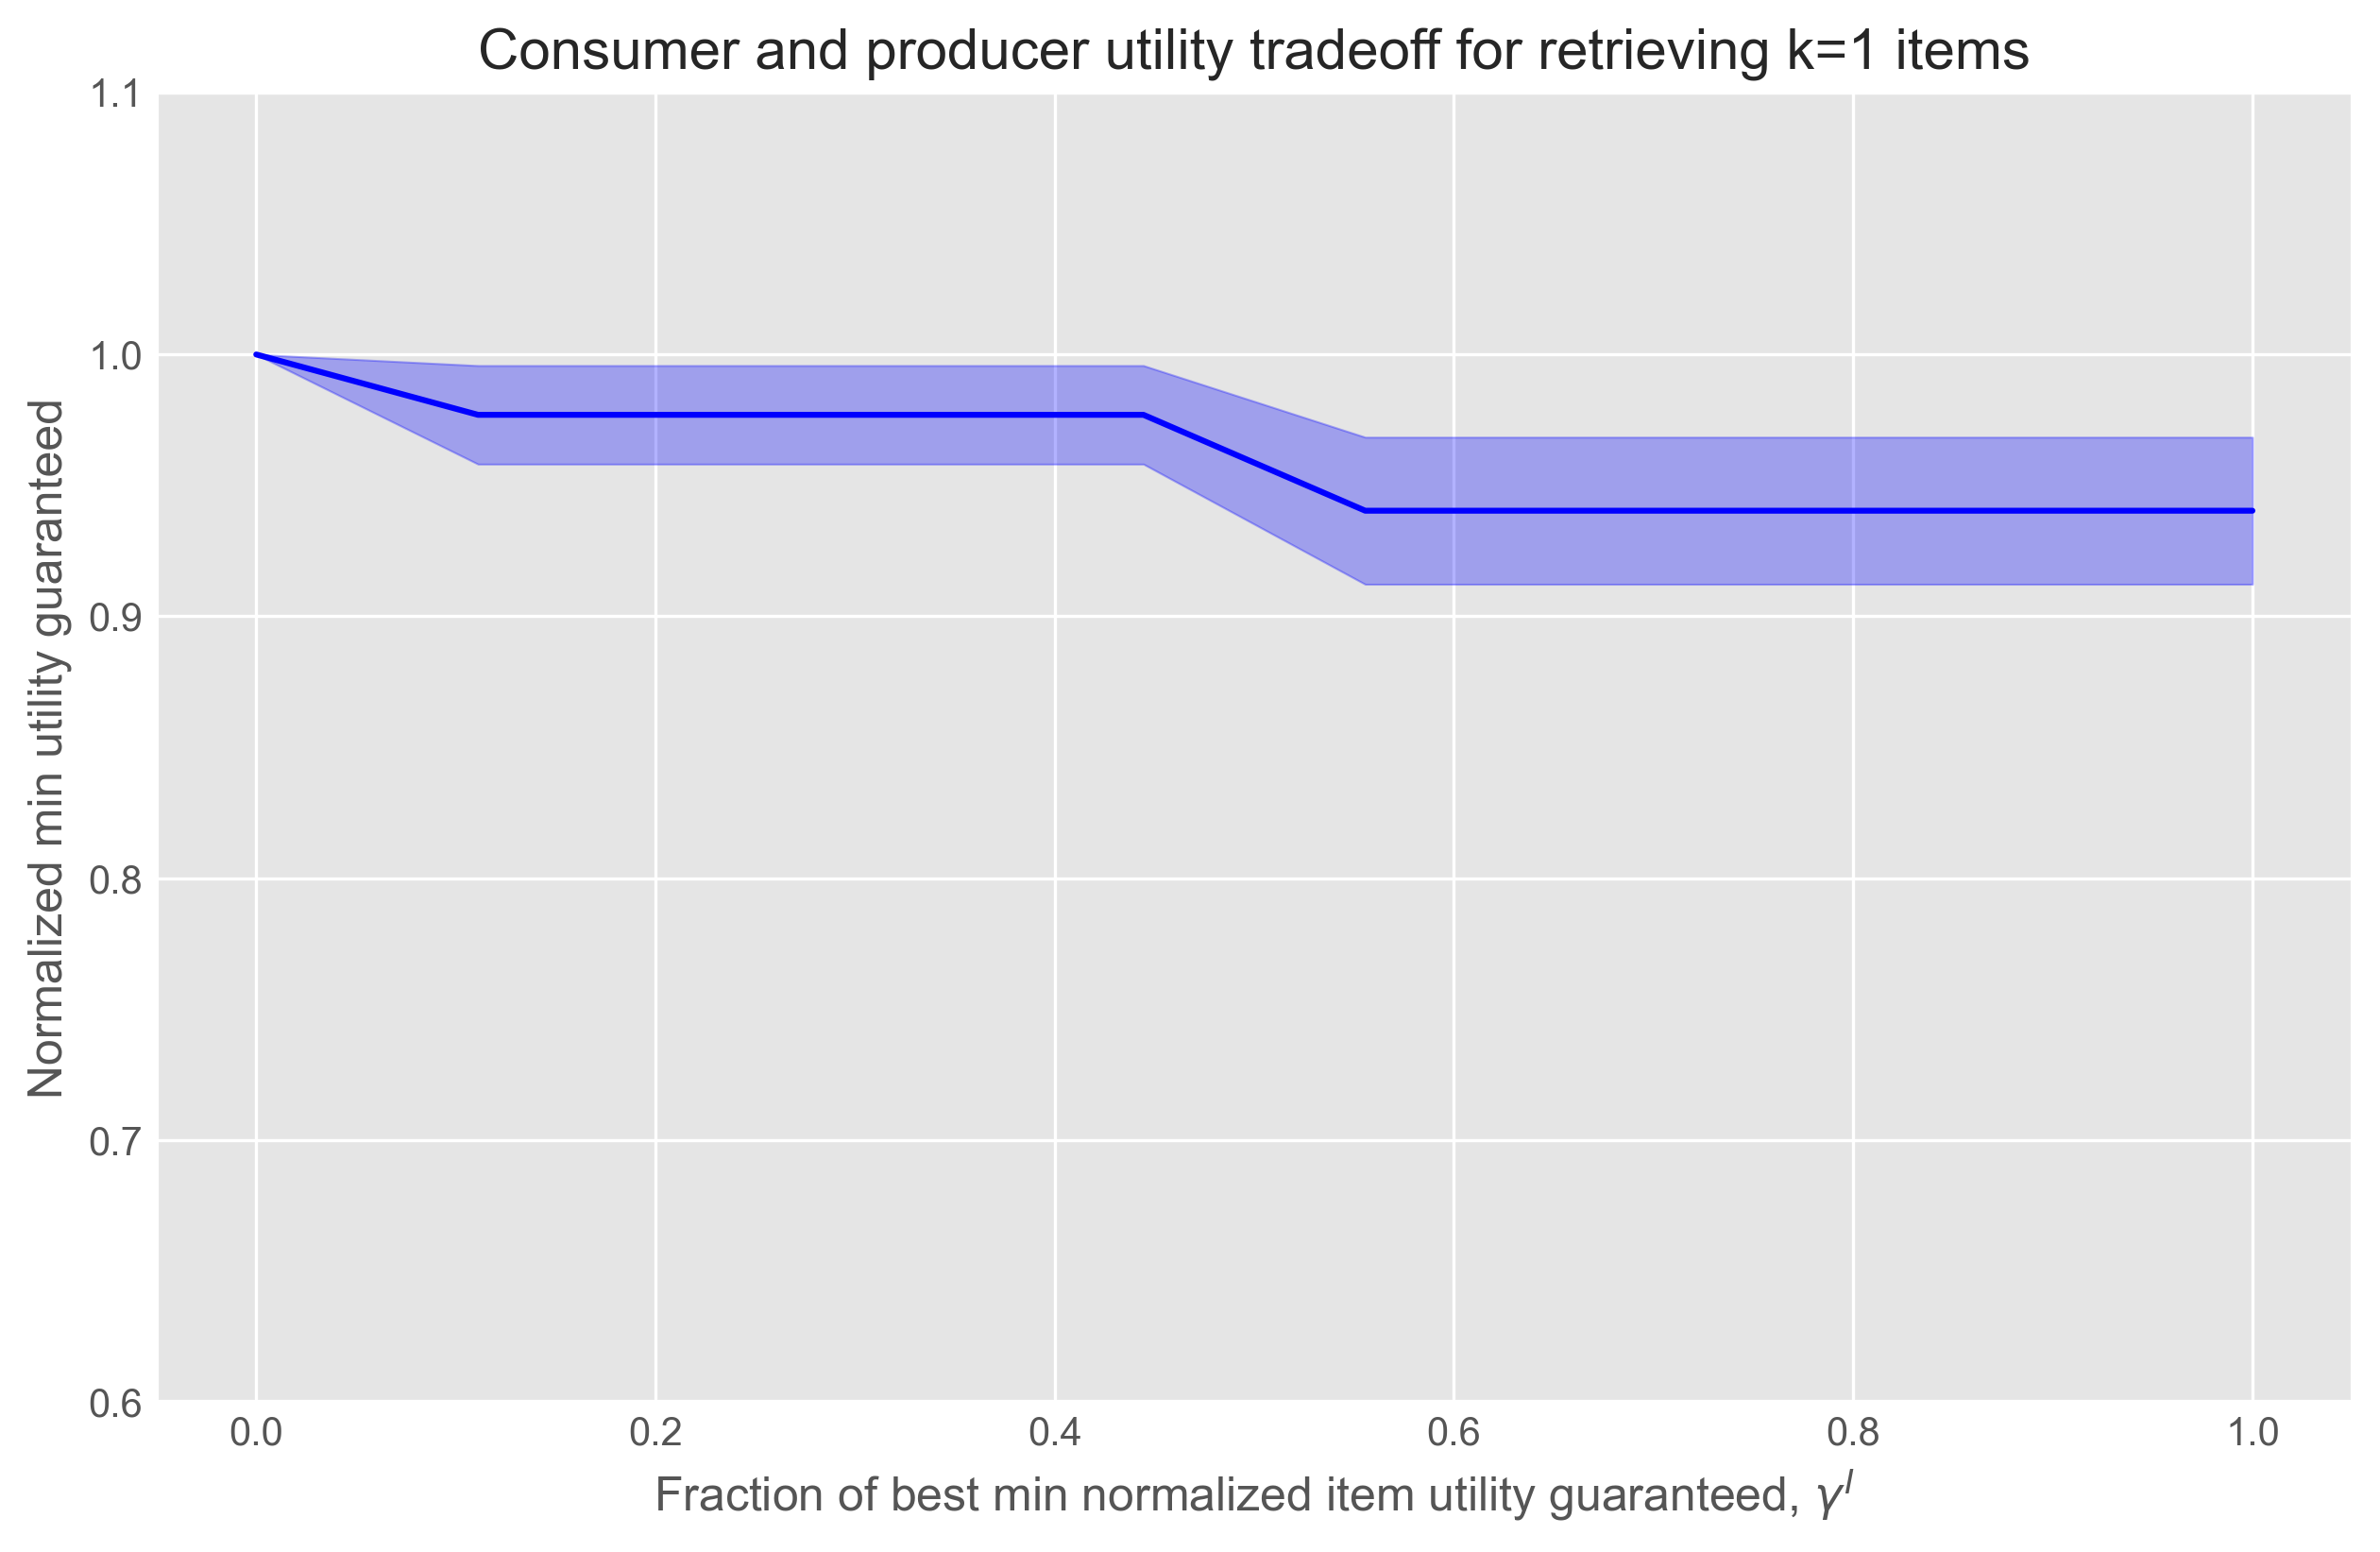

In [11]:
user_size = 100
items_size = 50
top_k = 1
n_runs = 10
gamma_points = np.linspace(0, 1, 10)
group_name = "usage_group"
all_empirical_pairs, users_ids, u_utils = get_curves_user_default(u_rel_matrx, user_size, items_size, n_runs, gamma_points, top_k, user_groups, group_name)

plt.figure(figsize=(10, 6), dpi=300)
plt.title("Consumer and producer utility tradeoff for retrieving k=1 items")
plt.plot(gamma_points, np.mean(all_empirical_pairs[:,:,1], axis=0), color='blue')
standard_err = np.std(all_empirical_pairs[:,:,1], axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(all_empirical_pairs[:,:,1], axis=0) - 2* standard_err, np.mean(all_empirical_pairs[:,:,1], axis=0) + 2*standard_err, alpha=0.3, color='blue')
plt.ylabel('Normalized min utility guaranteed')
plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
plt.ylim([0.6,1.1])
plt.savefig("./media9/producer_consumer_tradeoff_k1.png")

100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


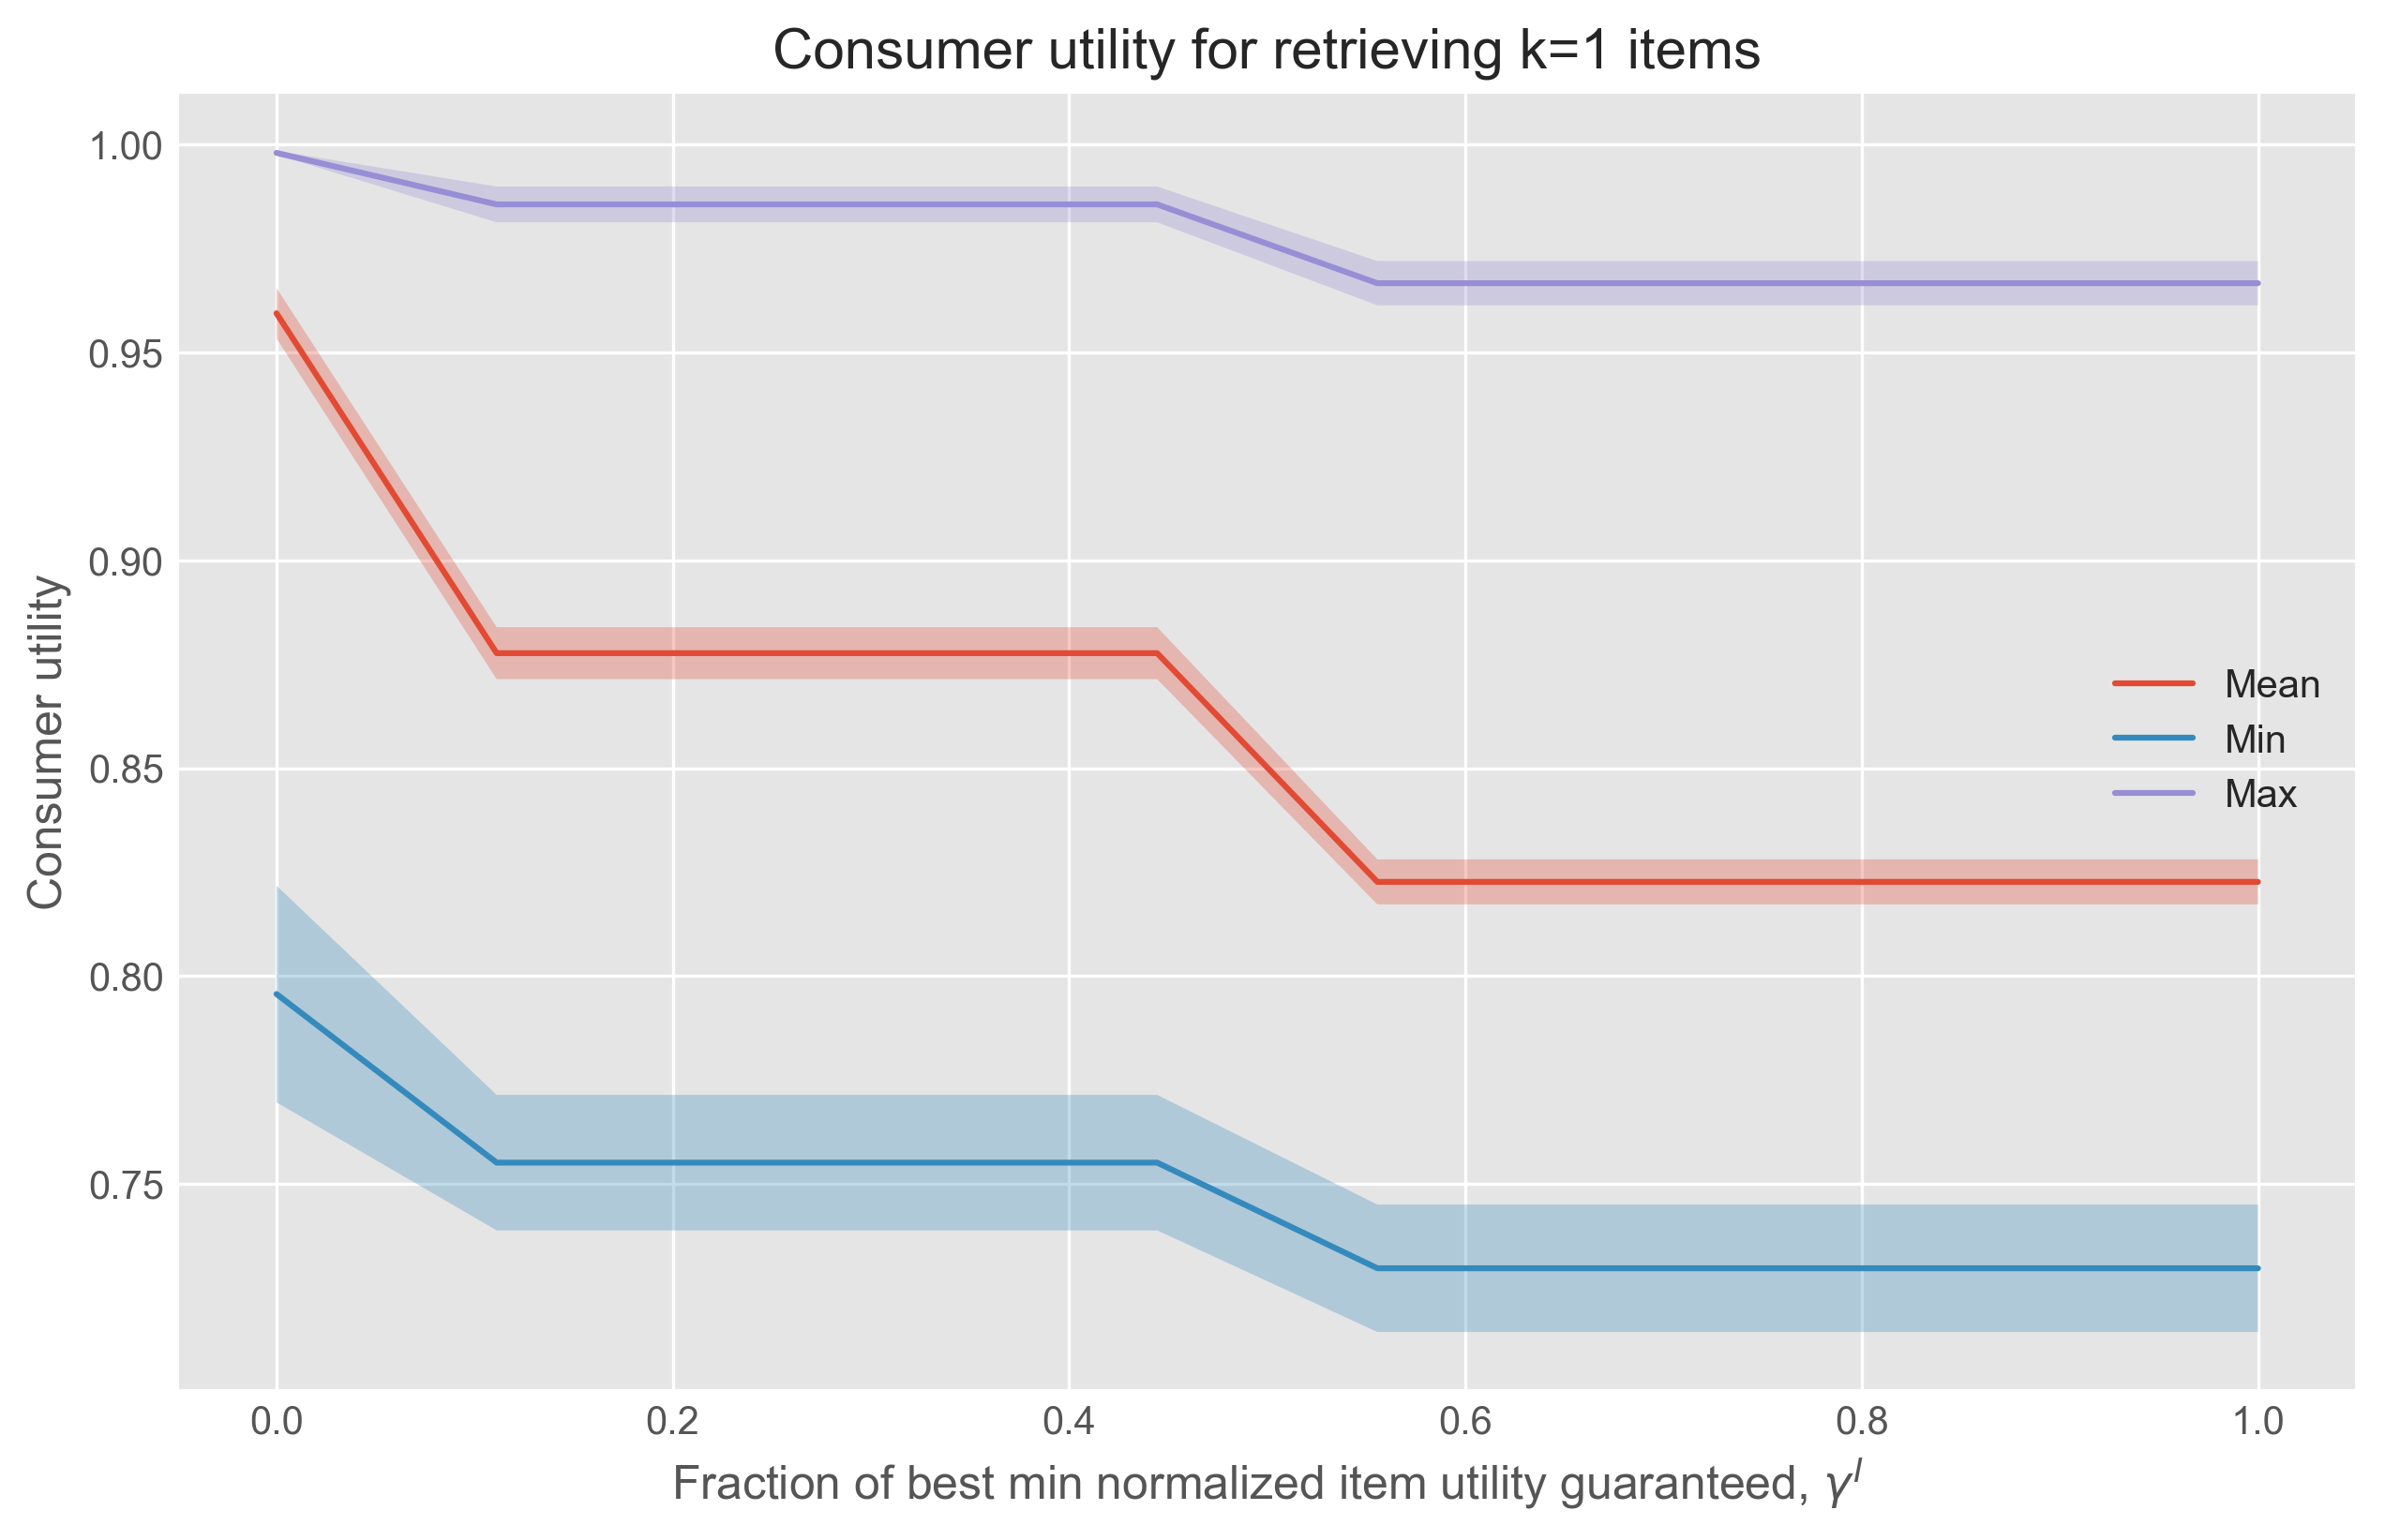

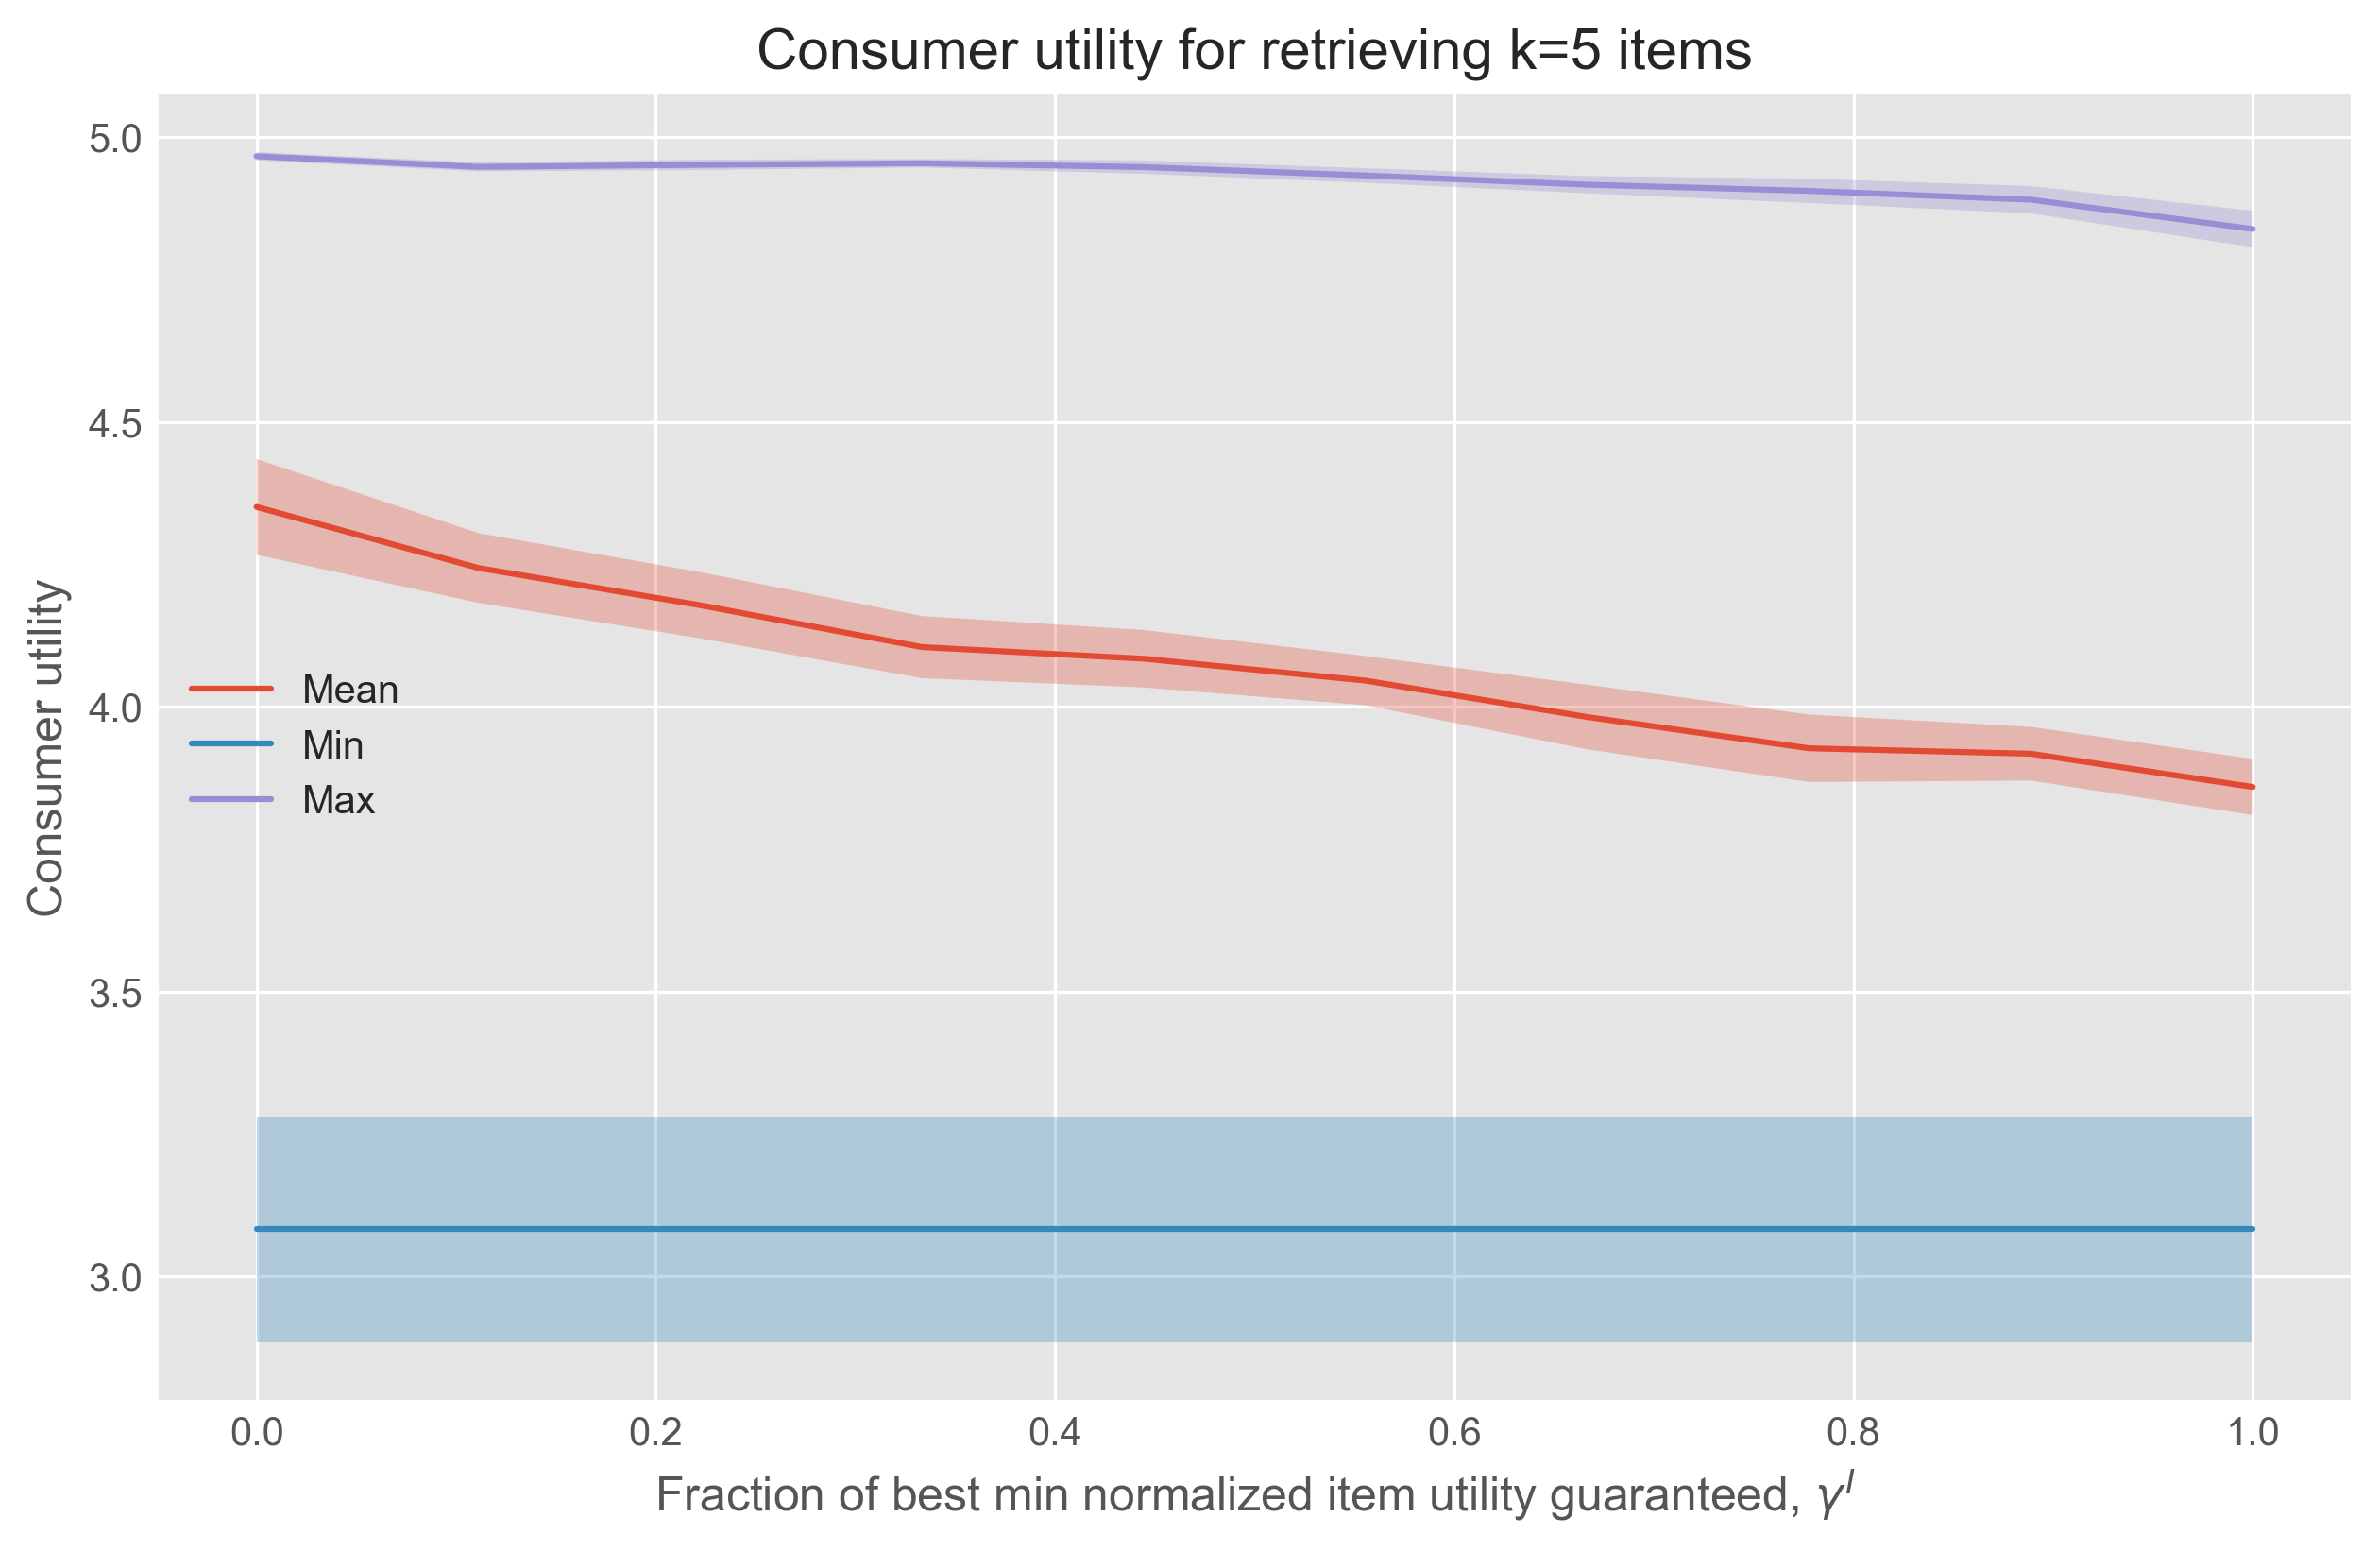

In [86]:
user_size = 100
items_size = 50
top_k = 1
n_runs = 10
gamma_points = np.linspace(0, 1, 10)
group_name = "usage_group"
#all_empirical_pairs, users_ids, u_utils = get_curves_user_default(u_rel_matrx, user_size, items_size, n_runs, gamma_points, top_k, user_groups, group_name)

mean_u_utils = [[np.mean(gamma) for gamma in run] for run in u_utils]
min_u_utils = [[np.min(gamma) for gamma in run] for run in u_utils]
max_u_utils = [[np.max(gamma) for gamma in run] for run in u_utils]

plt.figure(figsize=(10, 6), dpi=300)
plt.title("Consumer utility for retrieving k=1 items")
plt.plot(gamma_points, np.mean(mean_u_utils, axis=0), label="Mean")
standard_err = np.std(mean_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(mean_u_utils, axis=0) - standard_err, np.mean(mean_u_utils, axis=0) + standard_err, alpha=0.3)
plt.plot(gamma_points, np.mean(min_u_utils, axis=0), label="Min")
standard_err = np.std(min_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(min_u_utils, axis=0) - standard_err, np.mean(min_u_utils, axis=0) + standard_err, alpha=0.3)
plt.plot(gamma_points, np.mean(max_u_utils, axis=0), label="Max")
standard_err = np.std(max_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(max_u_utils, axis=0) - standard_err, np.mean(max_u_utils, axis=0) + standard_err, alpha=0.3)
plt.ylabel('Consumer utility')
plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
plt.legend()
plt.savefig("./media9/consumer_utility_k1.png")


user_size = 100
items_size = 50
top_k = 5
n_runs = 10
gamma_points = np.linspace(0, 1, 10)
group_name = "usage_group"
all_empirical_pairs, users_ids, u_utils = get_curves_user_default(u_rel_matrx, user_size, items_size, n_runs, gamma_points, top_k, user_groups, group_name)

mean_u_utils = [[np.mean(gamma) for gamma in run] for run in u_utils]
min_u_utils = [[np.min(gamma) for gamma in run] for run in u_utils]
max_u_utils = [[np.max(gamma) for gamma in run] for run in u_utils]

plt.figure(figsize=(10, 6), dpi=300)
plt.title("Consumer utility for retrieving k=5 items")
plt.plot(gamma_points, np.mean(mean_u_utils, axis=0), label="Mean")
standard_err = np.std(mean_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(mean_u_utils, axis=0) - standard_err, np.mean(mean_u_utils, axis=0) + standard_err, alpha=0.3)
plt.plot(gamma_points, np.mean(min_u_utils, axis=0), label="Min")
standard_err = np.std(min_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(min_u_utils, axis=0) - standard_err, np.mean(min_u_utils, axis=0) + standard_err, alpha=0.3)
plt.plot(gamma_points, np.mean(max_u_utils, axis=0), label="Max")
standard_err = np.std(max_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(max_u_utils, axis=0) - standard_err, np.mean(max_u_utils, axis=0) + standard_err, alpha=0.3)
plt.ylabel('Consumer utility')
plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
plt.legend()
plt.savefig("./media9/consumer_utility_k5.png")

100%|██████████| 10/10 [00:37<00:00,  3.76s/it]


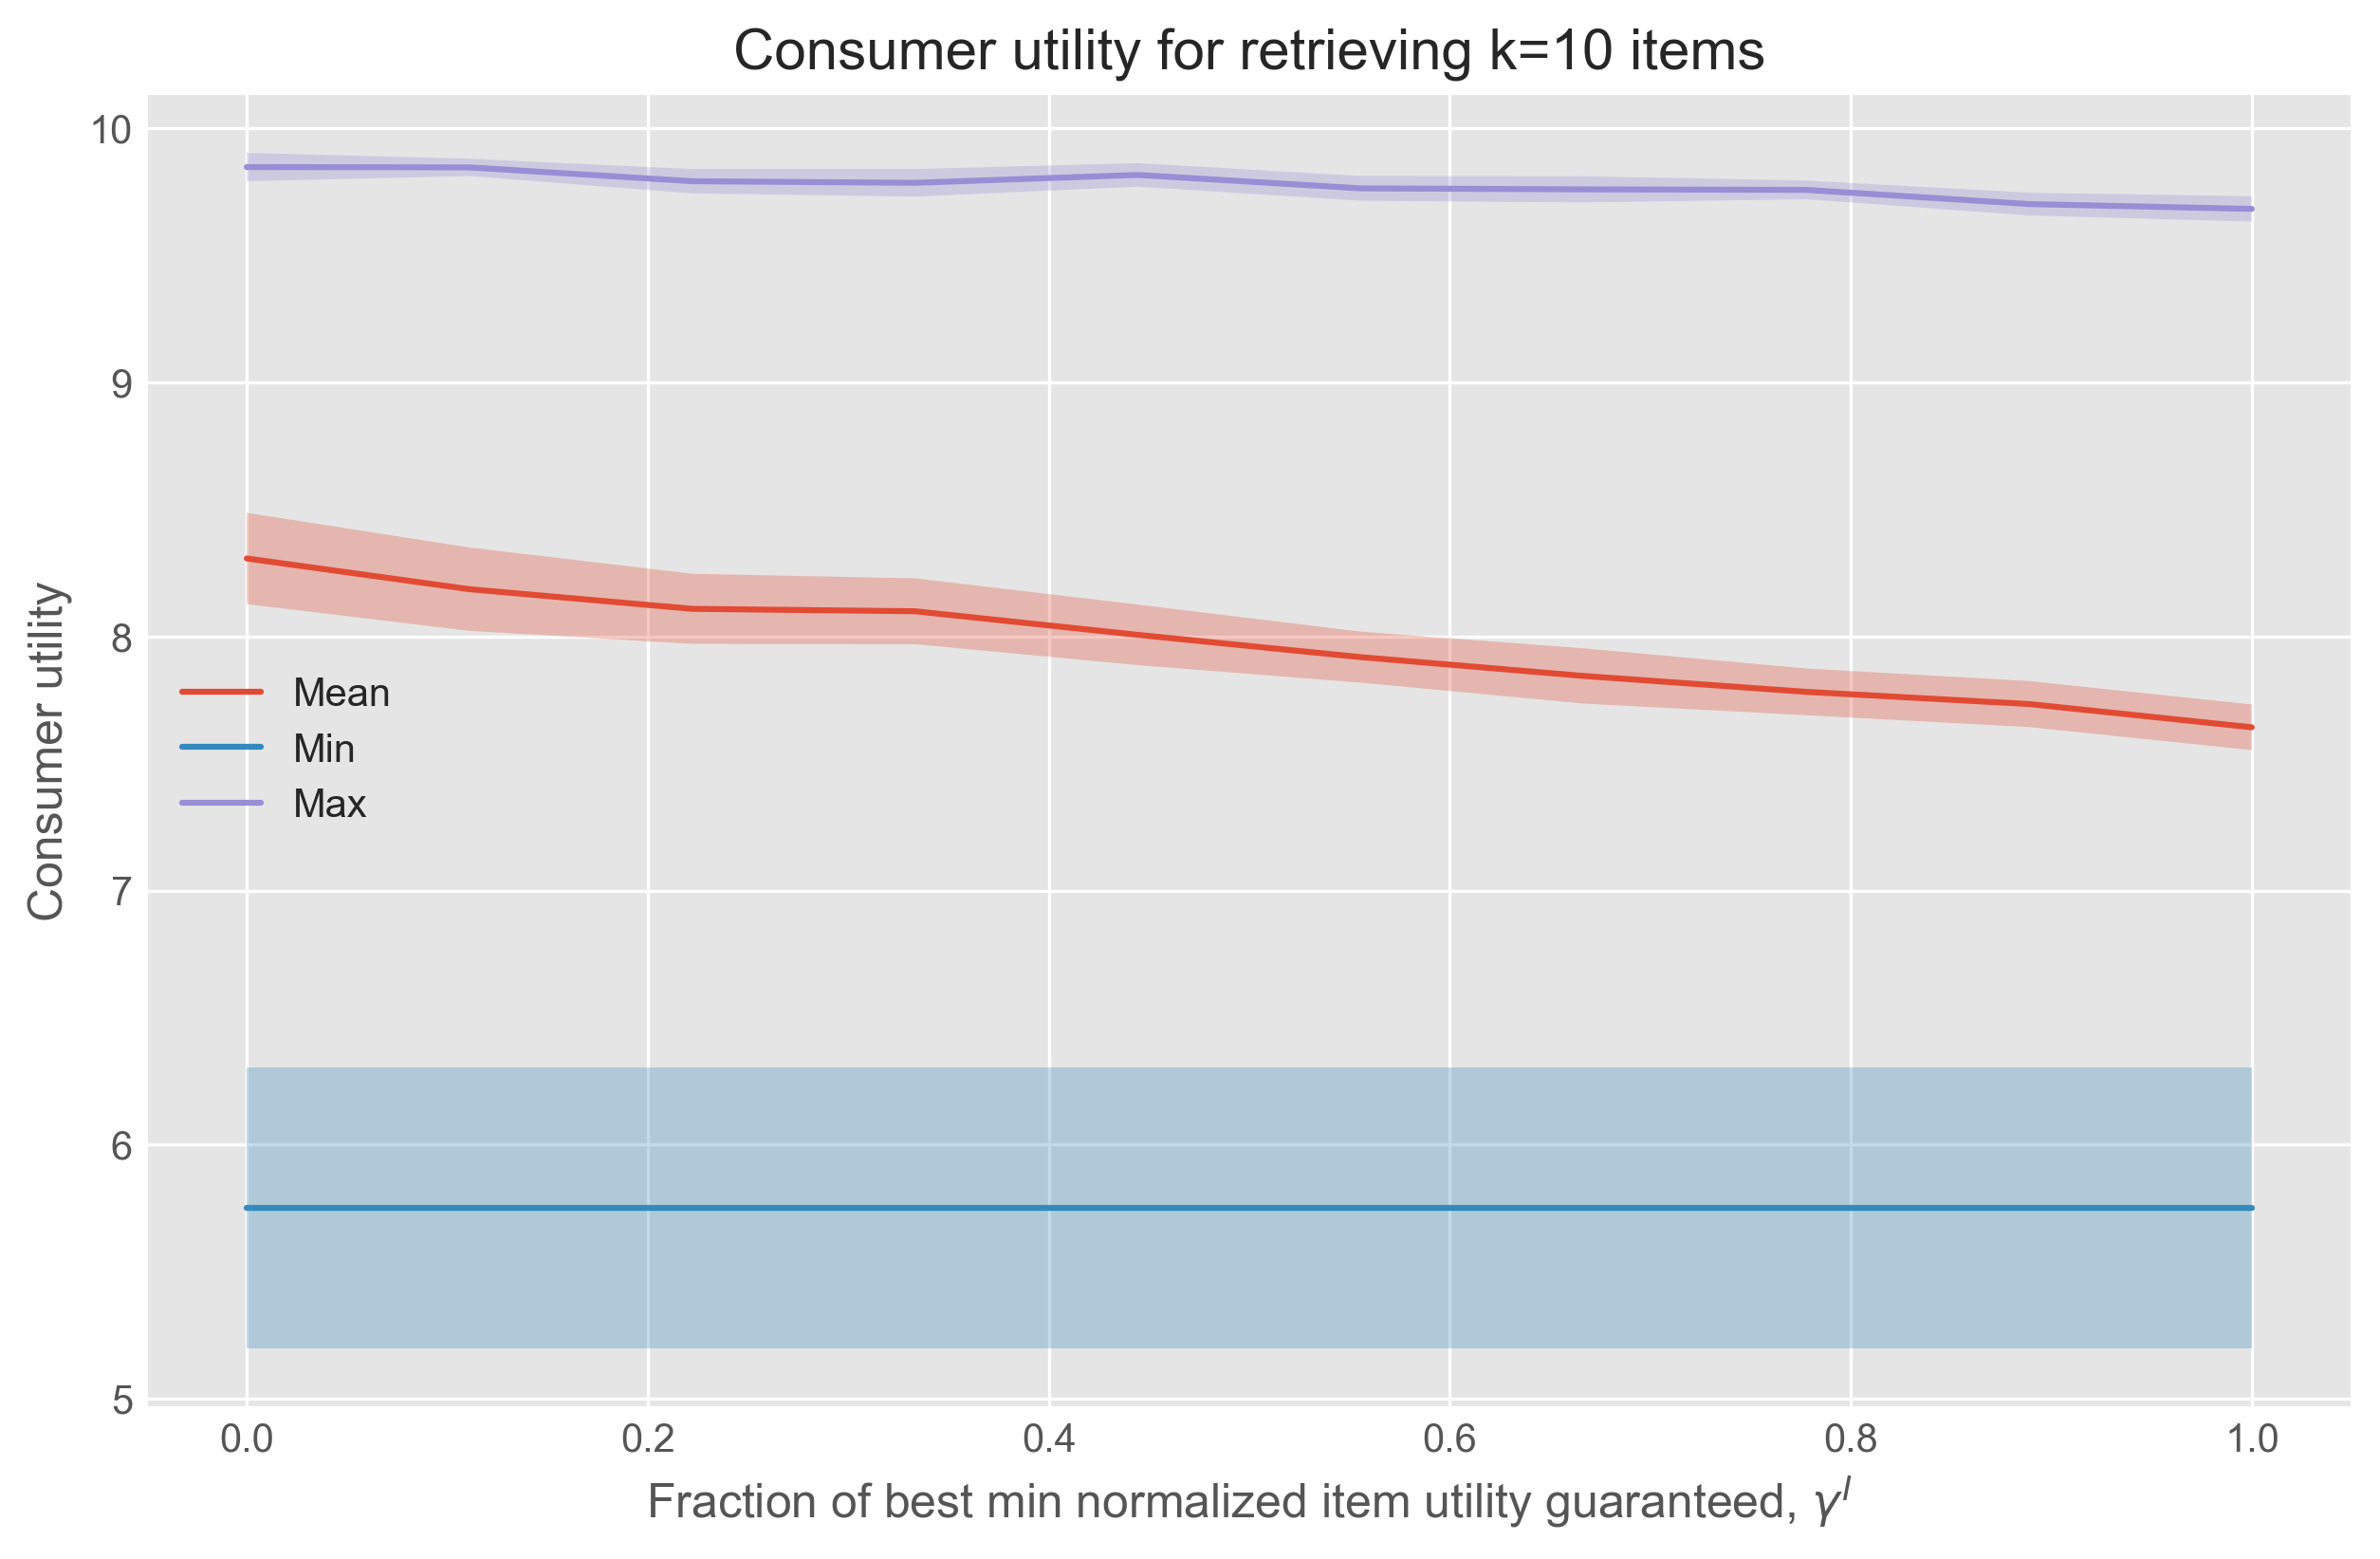

In [87]:
user_size = 100
items_size = 50
top_k = 10
n_runs = 10
gamma_points = np.linspace(0, 1, 10)
group_name = "usage_group"
all_empirical_pairs, users_ids, u_utils = get_curves_user_default(u_rel_matrx, user_size, items_size, n_runs, gamma_points, top_k, user_groups, group_name)

mean_u_utils = [[np.mean(gamma) for gamma in run] for run in u_utils]
min_u_utils = [[np.min(gamma) for gamma in run] for run in u_utils]
max_u_utils = [[np.max(gamma) for gamma in run] for run in u_utils]

plt.figure(figsize=(10, 6), dpi=300)
plt.title("Consumer utility for retrieving k=10 items")
plt.plot(gamma_points, np.mean(mean_u_utils, axis=0), label="Mean")
standard_err = np.std(mean_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(mean_u_utils, axis=0) - standard_err, np.mean(mean_u_utils, axis=0) + standard_err, alpha=0.3)
plt.plot(gamma_points, np.mean(min_u_utils, axis=0), label="Min")
standard_err = np.std(min_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(min_u_utils, axis=0) - standard_err, np.mean(min_u_utils, axis=0) + standard_err, alpha=0.3)
plt.plot(gamma_points, np.mean(max_u_utils, axis=0), label="Max")
standard_err = np.std(max_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(max_u_utils, axis=0) - standard_err, np.mean(max_u_utils, axis=0) + standard_err, alpha=0.3)
plt.ylabel('Consumer utility')
plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
plt.legend()
plt.savefig("./media9/consumer_utility_k10.png")

  0%|          | 0/15 [00:00<?, ?it/s]

 87%|████████▋ | 13/15 [04:57<00:37, 18.58s/it]

pressed CTRL-C 1 times (5 times for forcing termination)


 87%|████████▋ | 13/15 [5:45:20<53:07, 1593.86s/it]


SolverError: Solver 'SCIP' failed. Try another solver, or solve with verbose=True for more information.

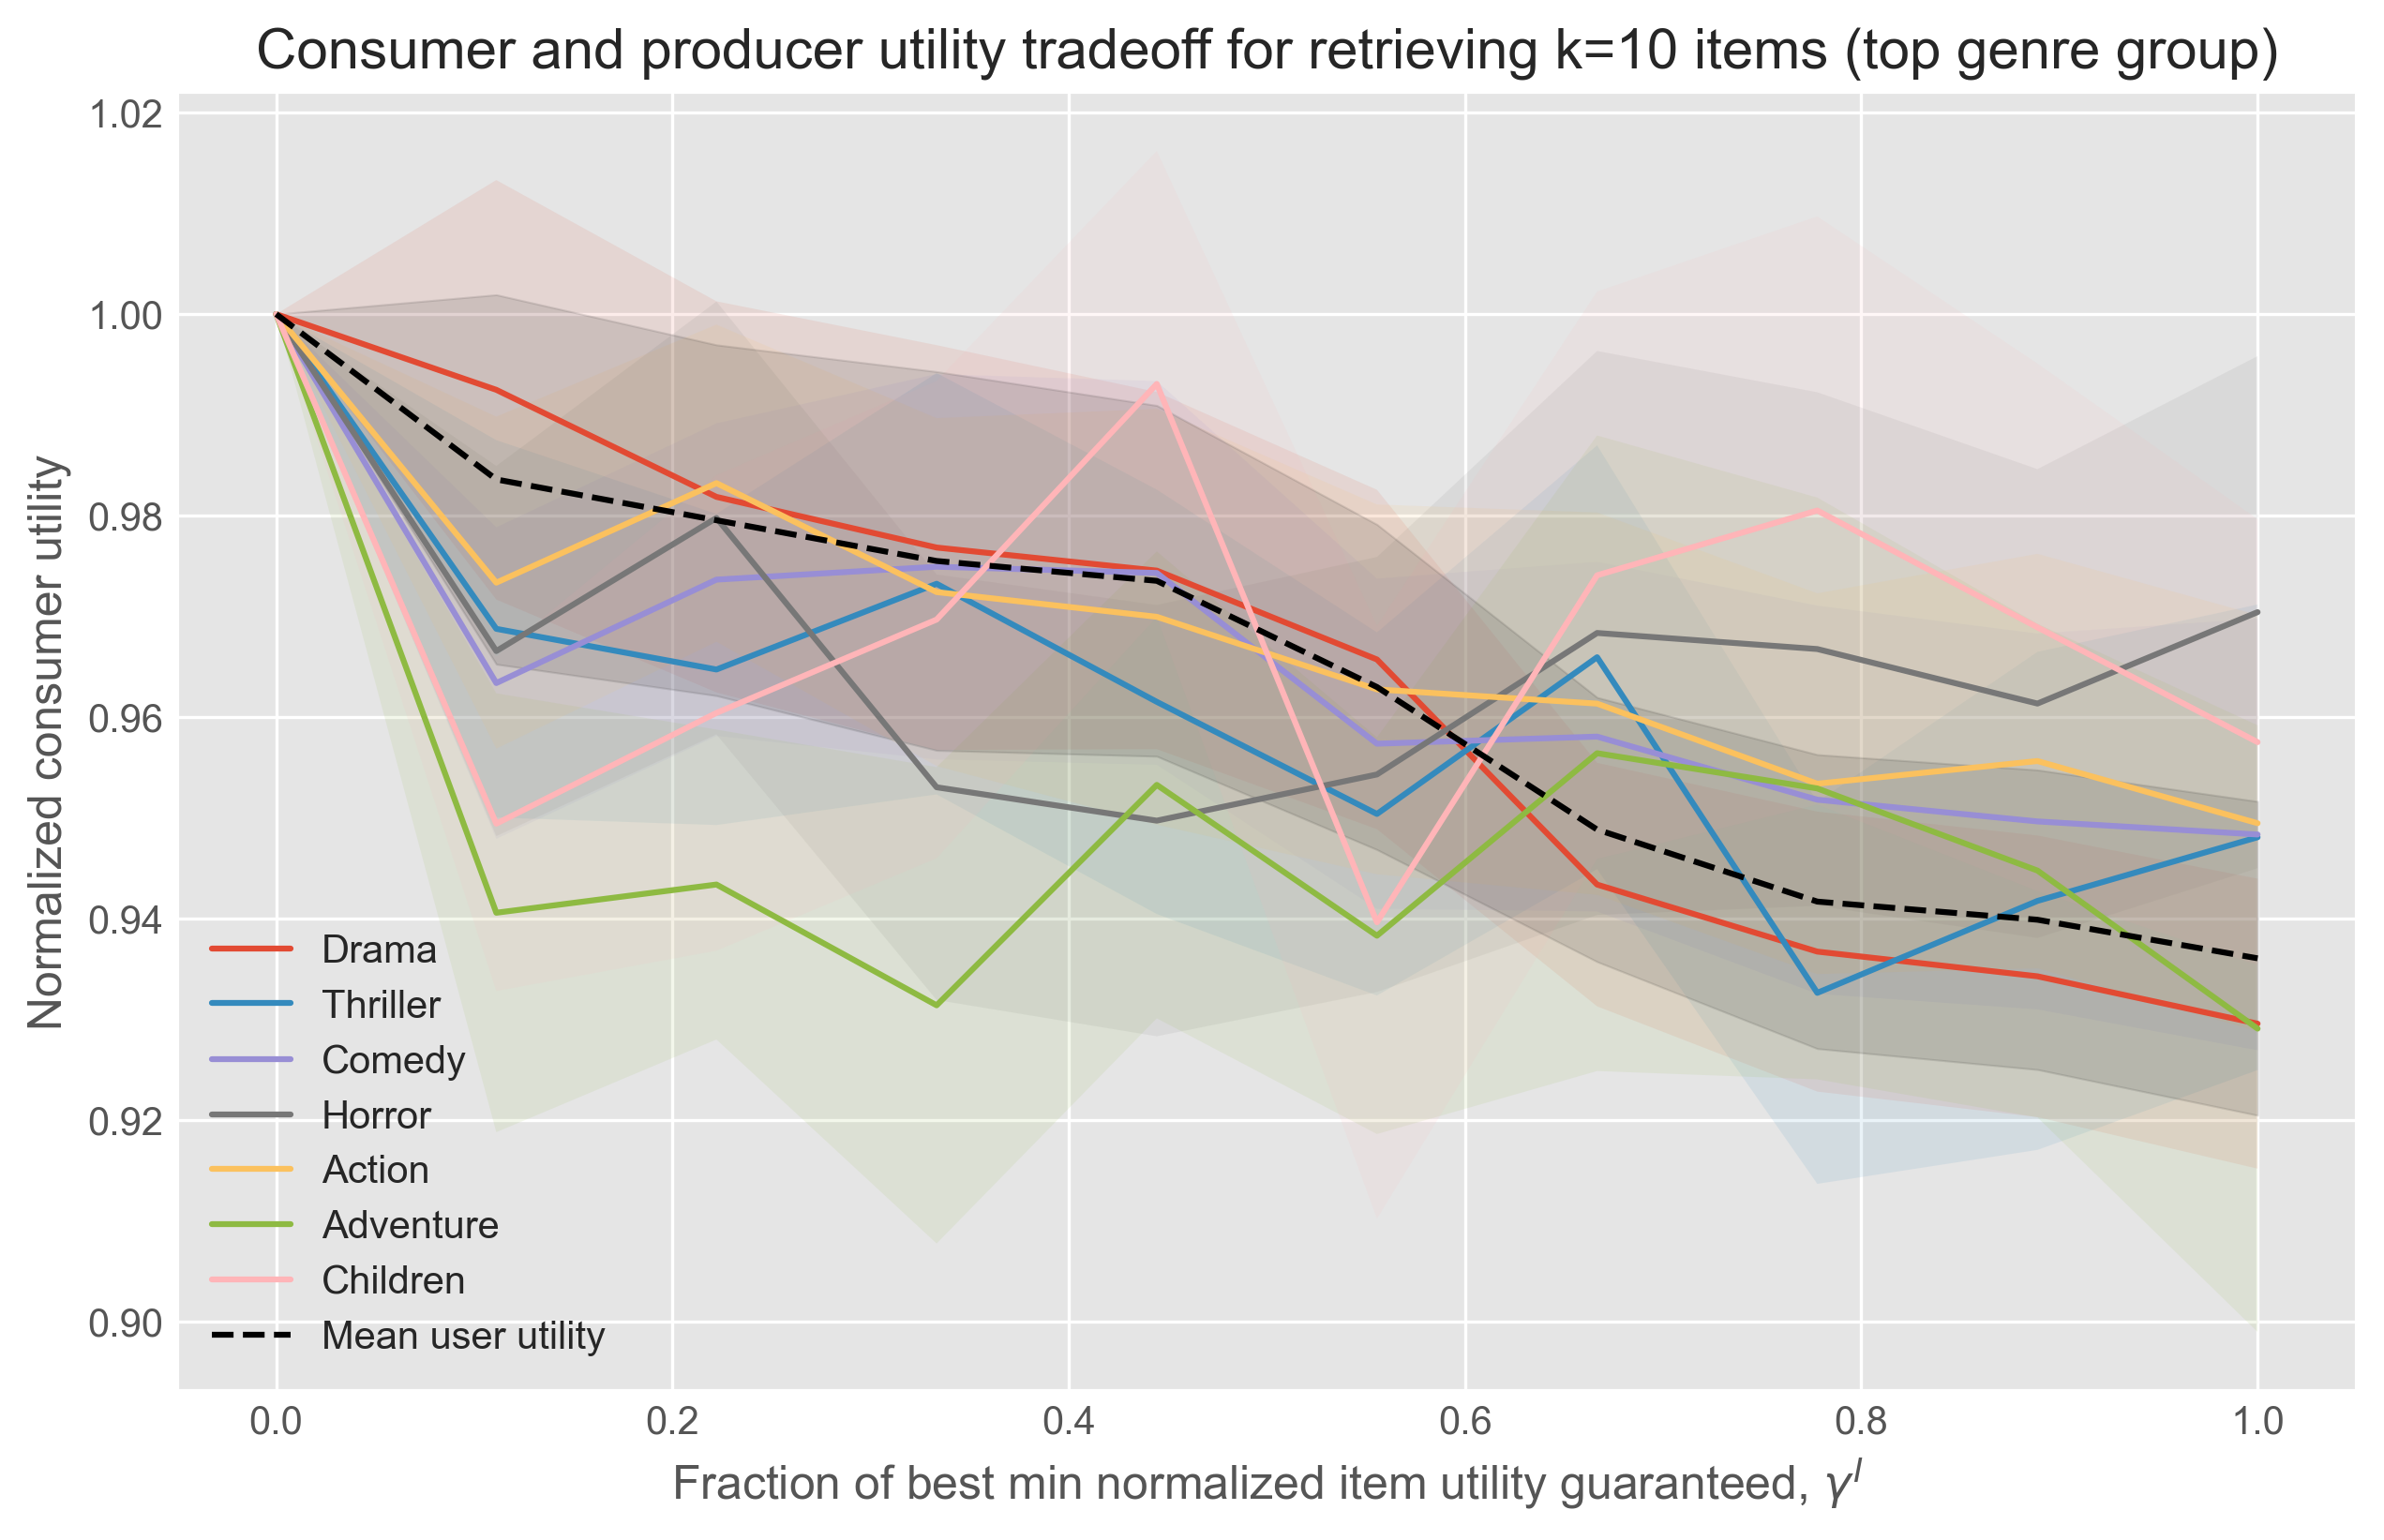

In [10]:
plt.style.use('ggplot')

for group_name in ["top_genre", "usage_group"]:
    gamma_points = np.linspace(0, 1, 10)
    n_runs = 15
    user_size = 300
    items_size = 100
    top_k = 10

    all_empirical_pairs, users_ids, u_utils = get_curves_user_groups(u_rel_matrx, user_size, items_size, n_runs, gamma_points, top_k, user_groups, group_name)

    results = defaultdict(dict)
    gammas = all_empirical_pairs[0,:,0]

    for gamma, _ in enumerate(gamma_points):
        group_utils_mean = defaultdict(list)
        for draw in range(n_runs):
            group_users = defaultdict(list)
            for row in user_groups:
                user_id = row["user_id"]
                if user_id in users_ids[draw]:
                    group_users[row[group_name]].append(users_ids[draw].index(user_id))

            for group, users in group_users.items():
                group_utils_mean[group].append(np.take(u_utils[draw][gamma], users).mean())

        for group, utils in group_utils_mean.items():
            results[group][gamma] = {"mean": np.mean(utils), "std": np.std(utils)}

    plt.figure(figsize=(10,6), dpi=300)
    for group, data in results.items():
        if group == "Romance":
            continue
        plt.plot(gammas, [i["mean"] for i in data.values()], label=group.capitalize())
        standard_err = np.array([i["std"] for i in data.values()]) / np.sqrt(n_runs)
        plt.fill_between(gammas, [i["mean"] for i in data.values()] - standard_err, [i["mean"] for i in data.values()] + standard_err, alpha=0.1)


    plt.ylabel('Normalized consumer utility')
    plt.title(f"Consumer and producer utility tradeoff for retrieving k=10 items ({group_name.replace("group", "").replace('_', ' ')} group)")
    plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
    mean_utils = np.array(u_utils).mean(axis=2)
    plt.plot(gammas, mean_utils.mean(axis=0), color="black", label="Mean user utility", linestyle="--")
    standard_err = np.std(mean_utils, axis=0) / np.sqrt(n_runs)
    plt.fill_between(gammas, np.array(u_utils).mean(axis=2).mean(axis=0) - standard_err, np.array(u_utils).mean(axis=2).mean(axis=0) + standard_err, alpha=0.1, color="black")
    plt.legend()
    plt.savefig(f"./media9/tradeoff_curve_group_{group_name}_user_size_{user_size}_items_{items_size}_n_draws_{n_runs}_top_k_{top_k}.png")

In [19]:
np.array(u_utils).mean(axis=2).shape

(1, 10)

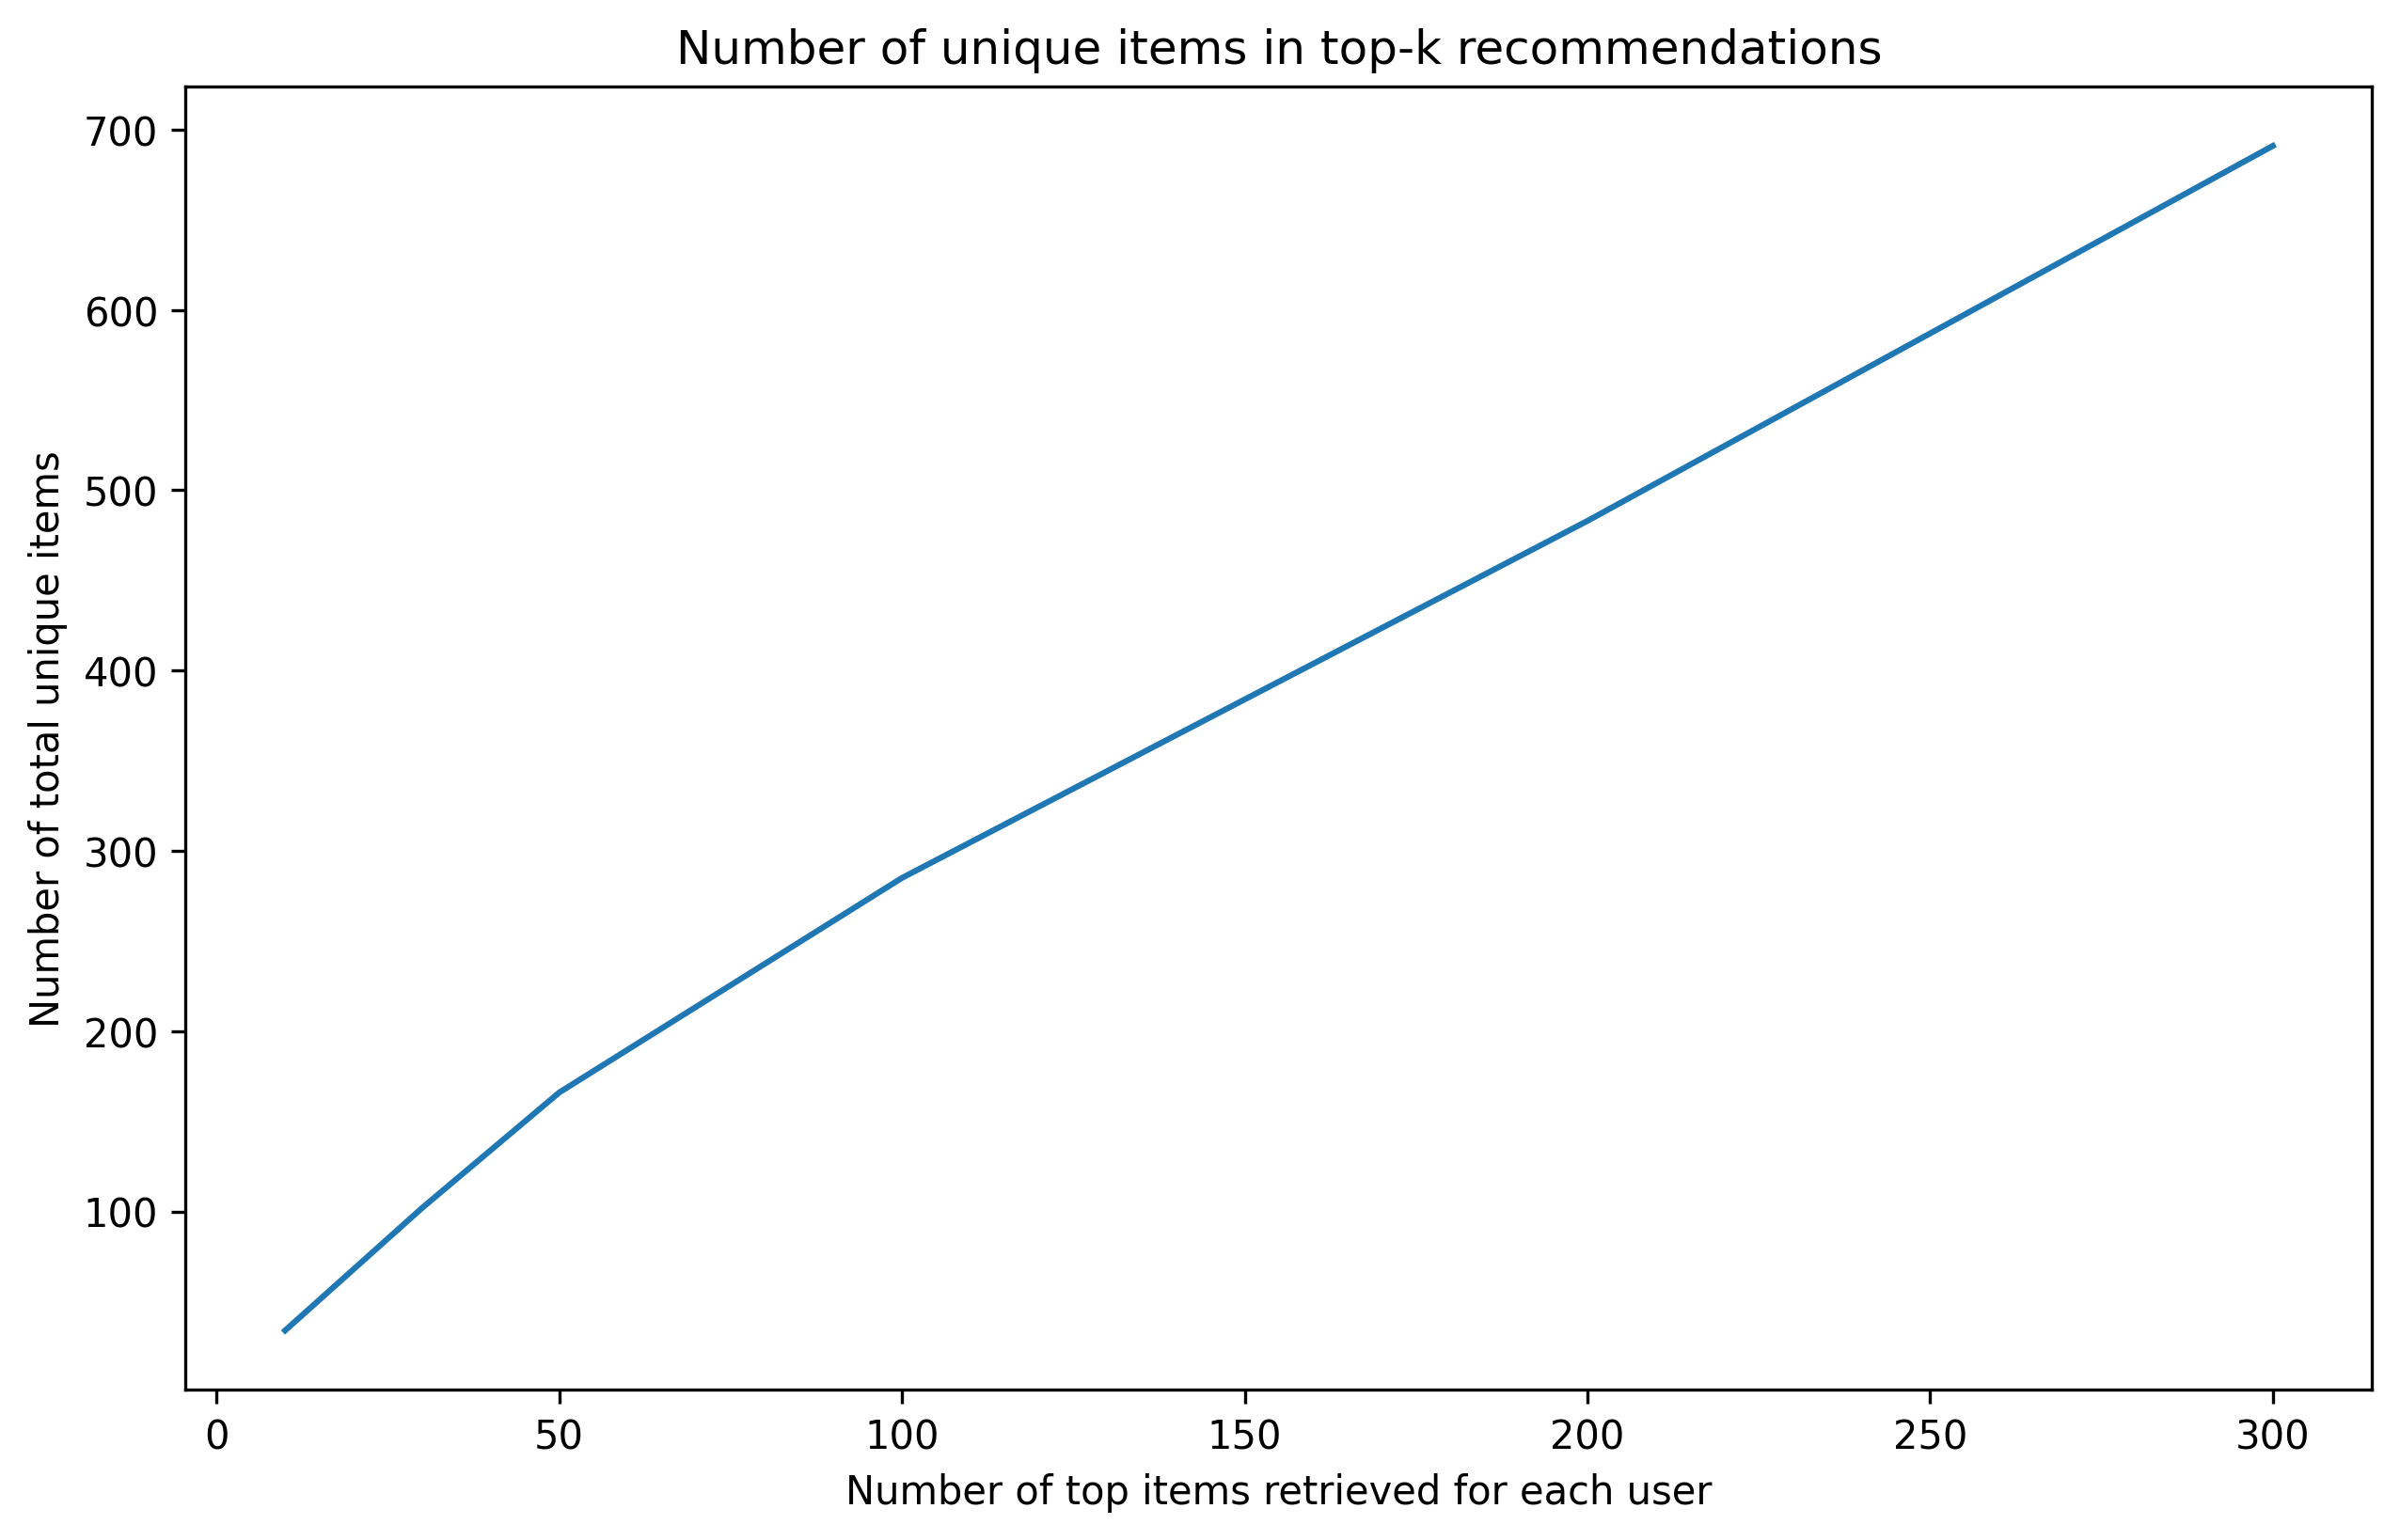

In [ ]:
sample_users = u_rel_matrx[np.random.default_rng().choice(N_USERS, size=300, replace=False)]
items_cnt = []

for k in [10, 20, 30, 50, 100, 200, 300]:
    sample = sample_candidate_items(sample_users, k)
    items_cnt.append(sample.shape[1])

plt.figure(figsize=(10,6), dpi=300)
plt.plot([10, 20, 30, 50, 100, 200, 300], items_cnt)
plt.xlabel("Number of top items retrieved for each user")
plt.ylabel("Number of total unique items")
plt.title("Number of unique items in top-k recommendations")
plt.savefig("./media7/unique_items_in_top_k.png")

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [05:28<00:00, 109.49s/it]


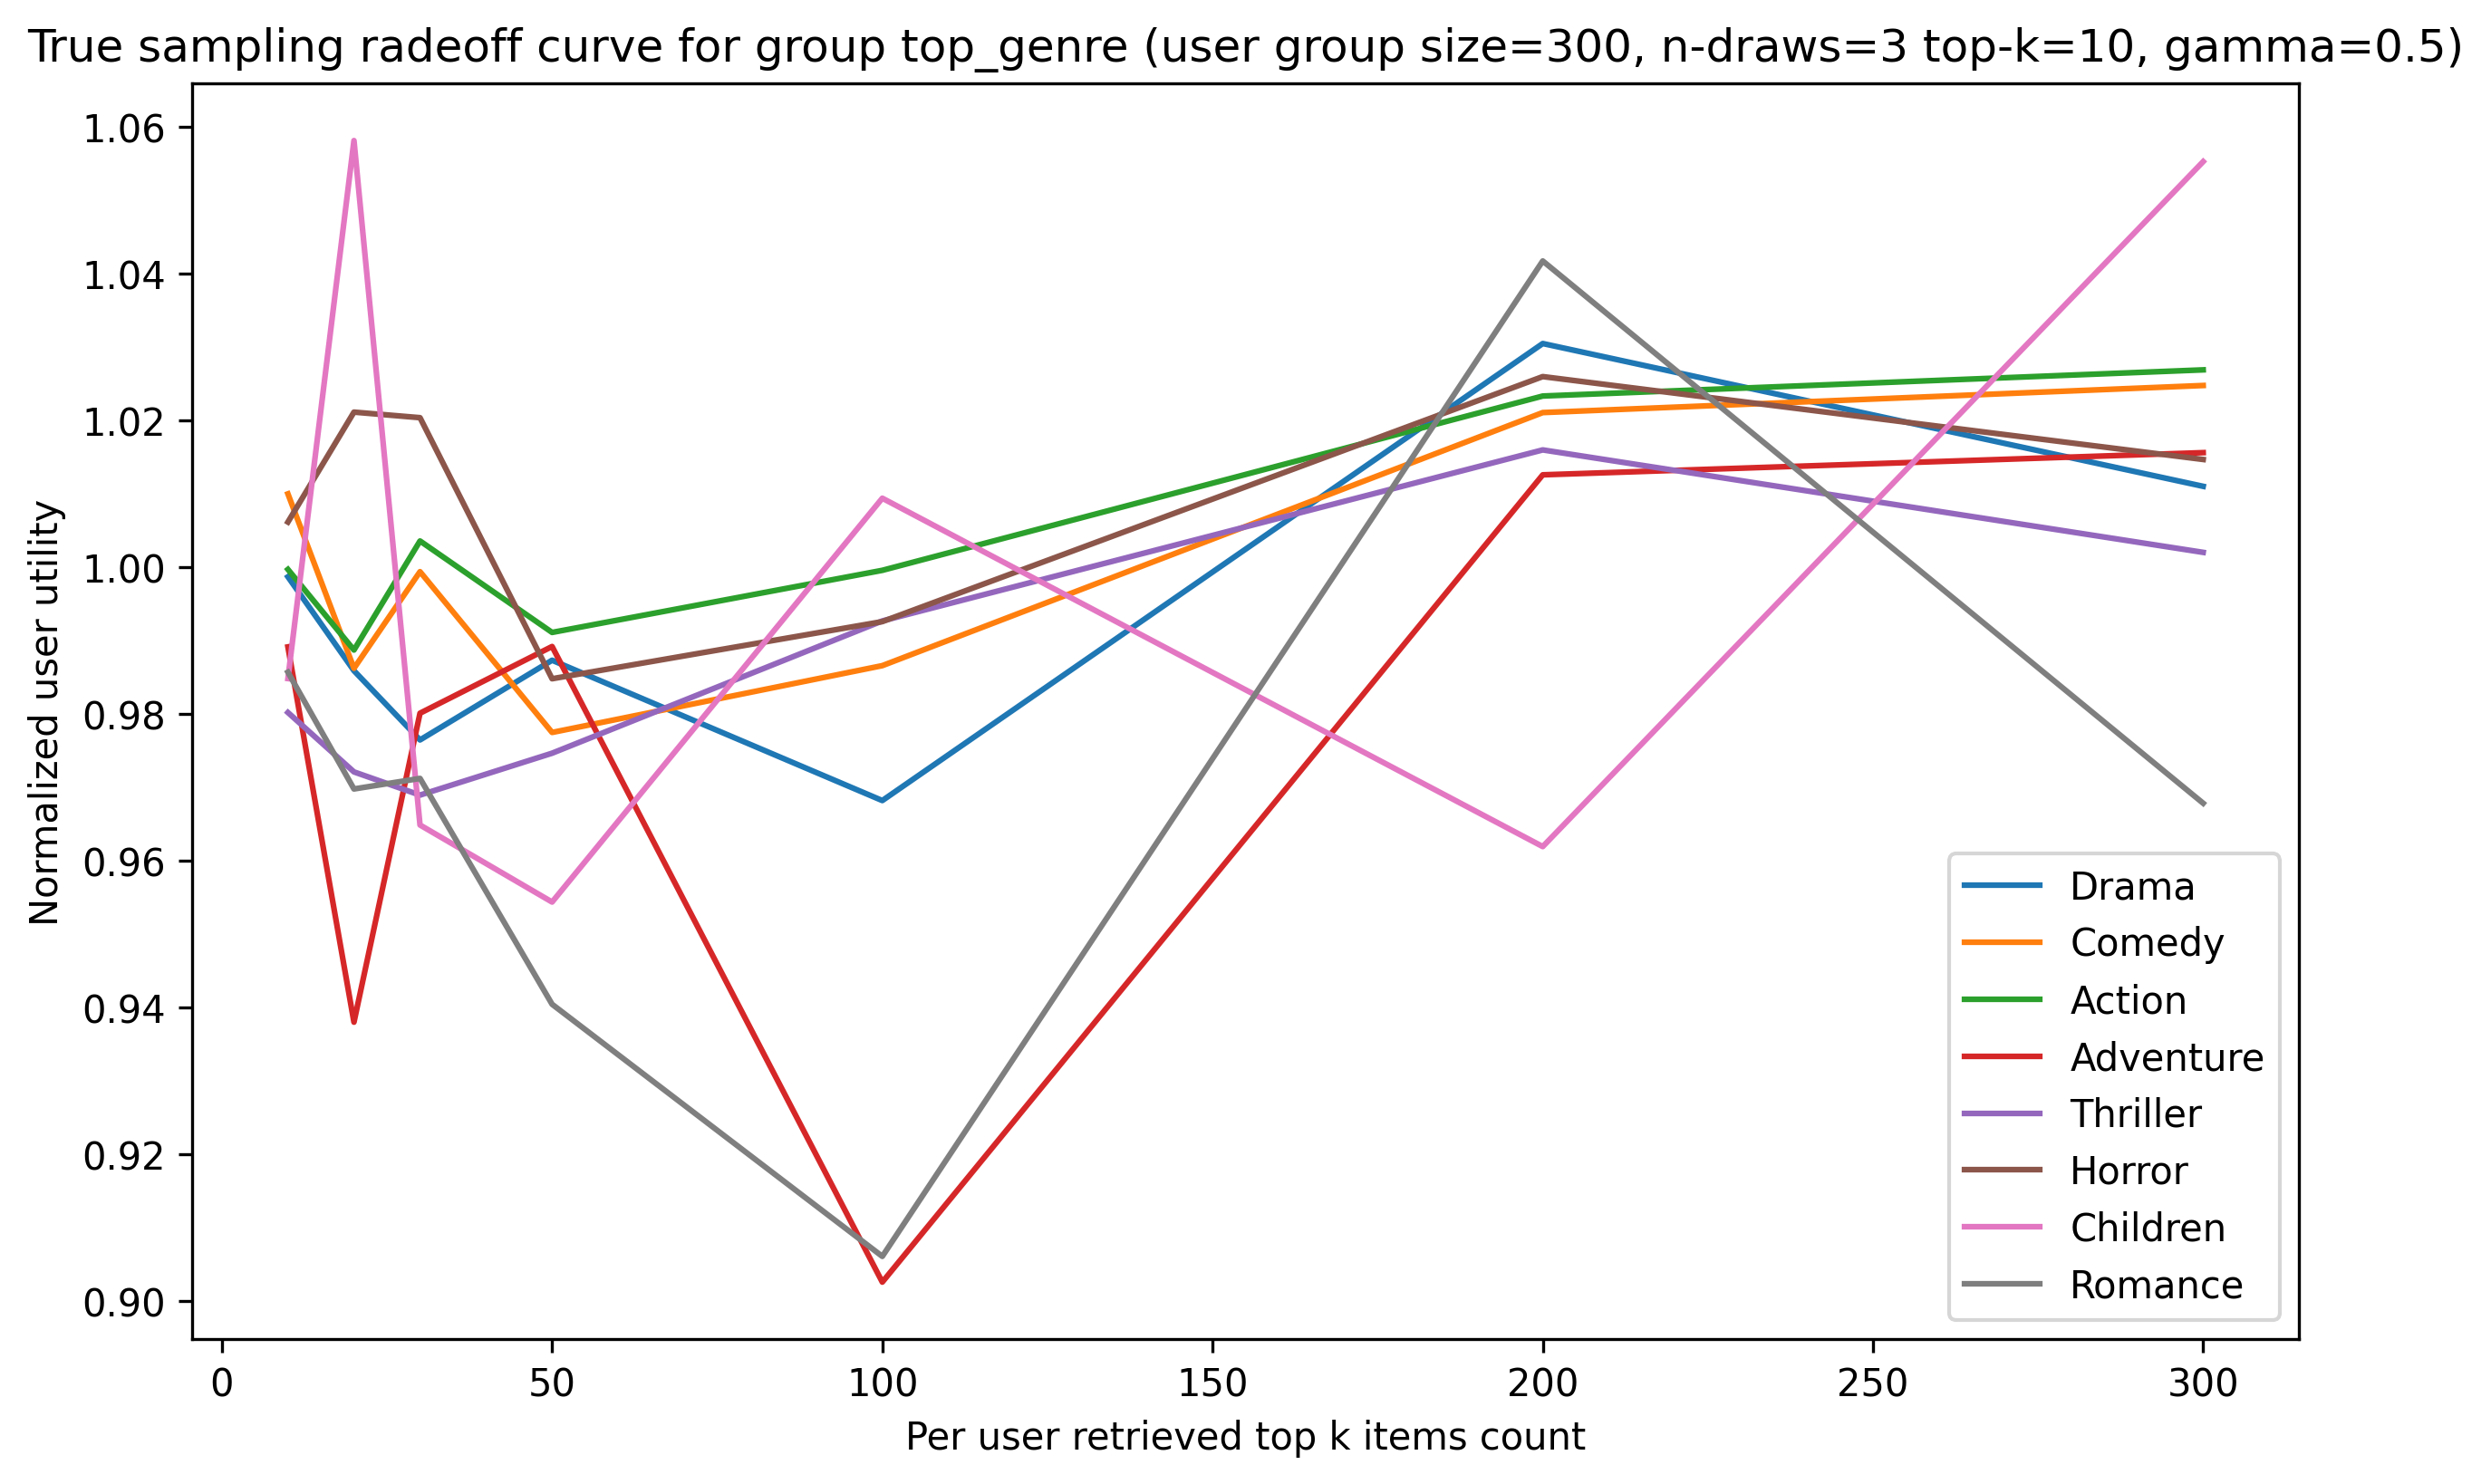

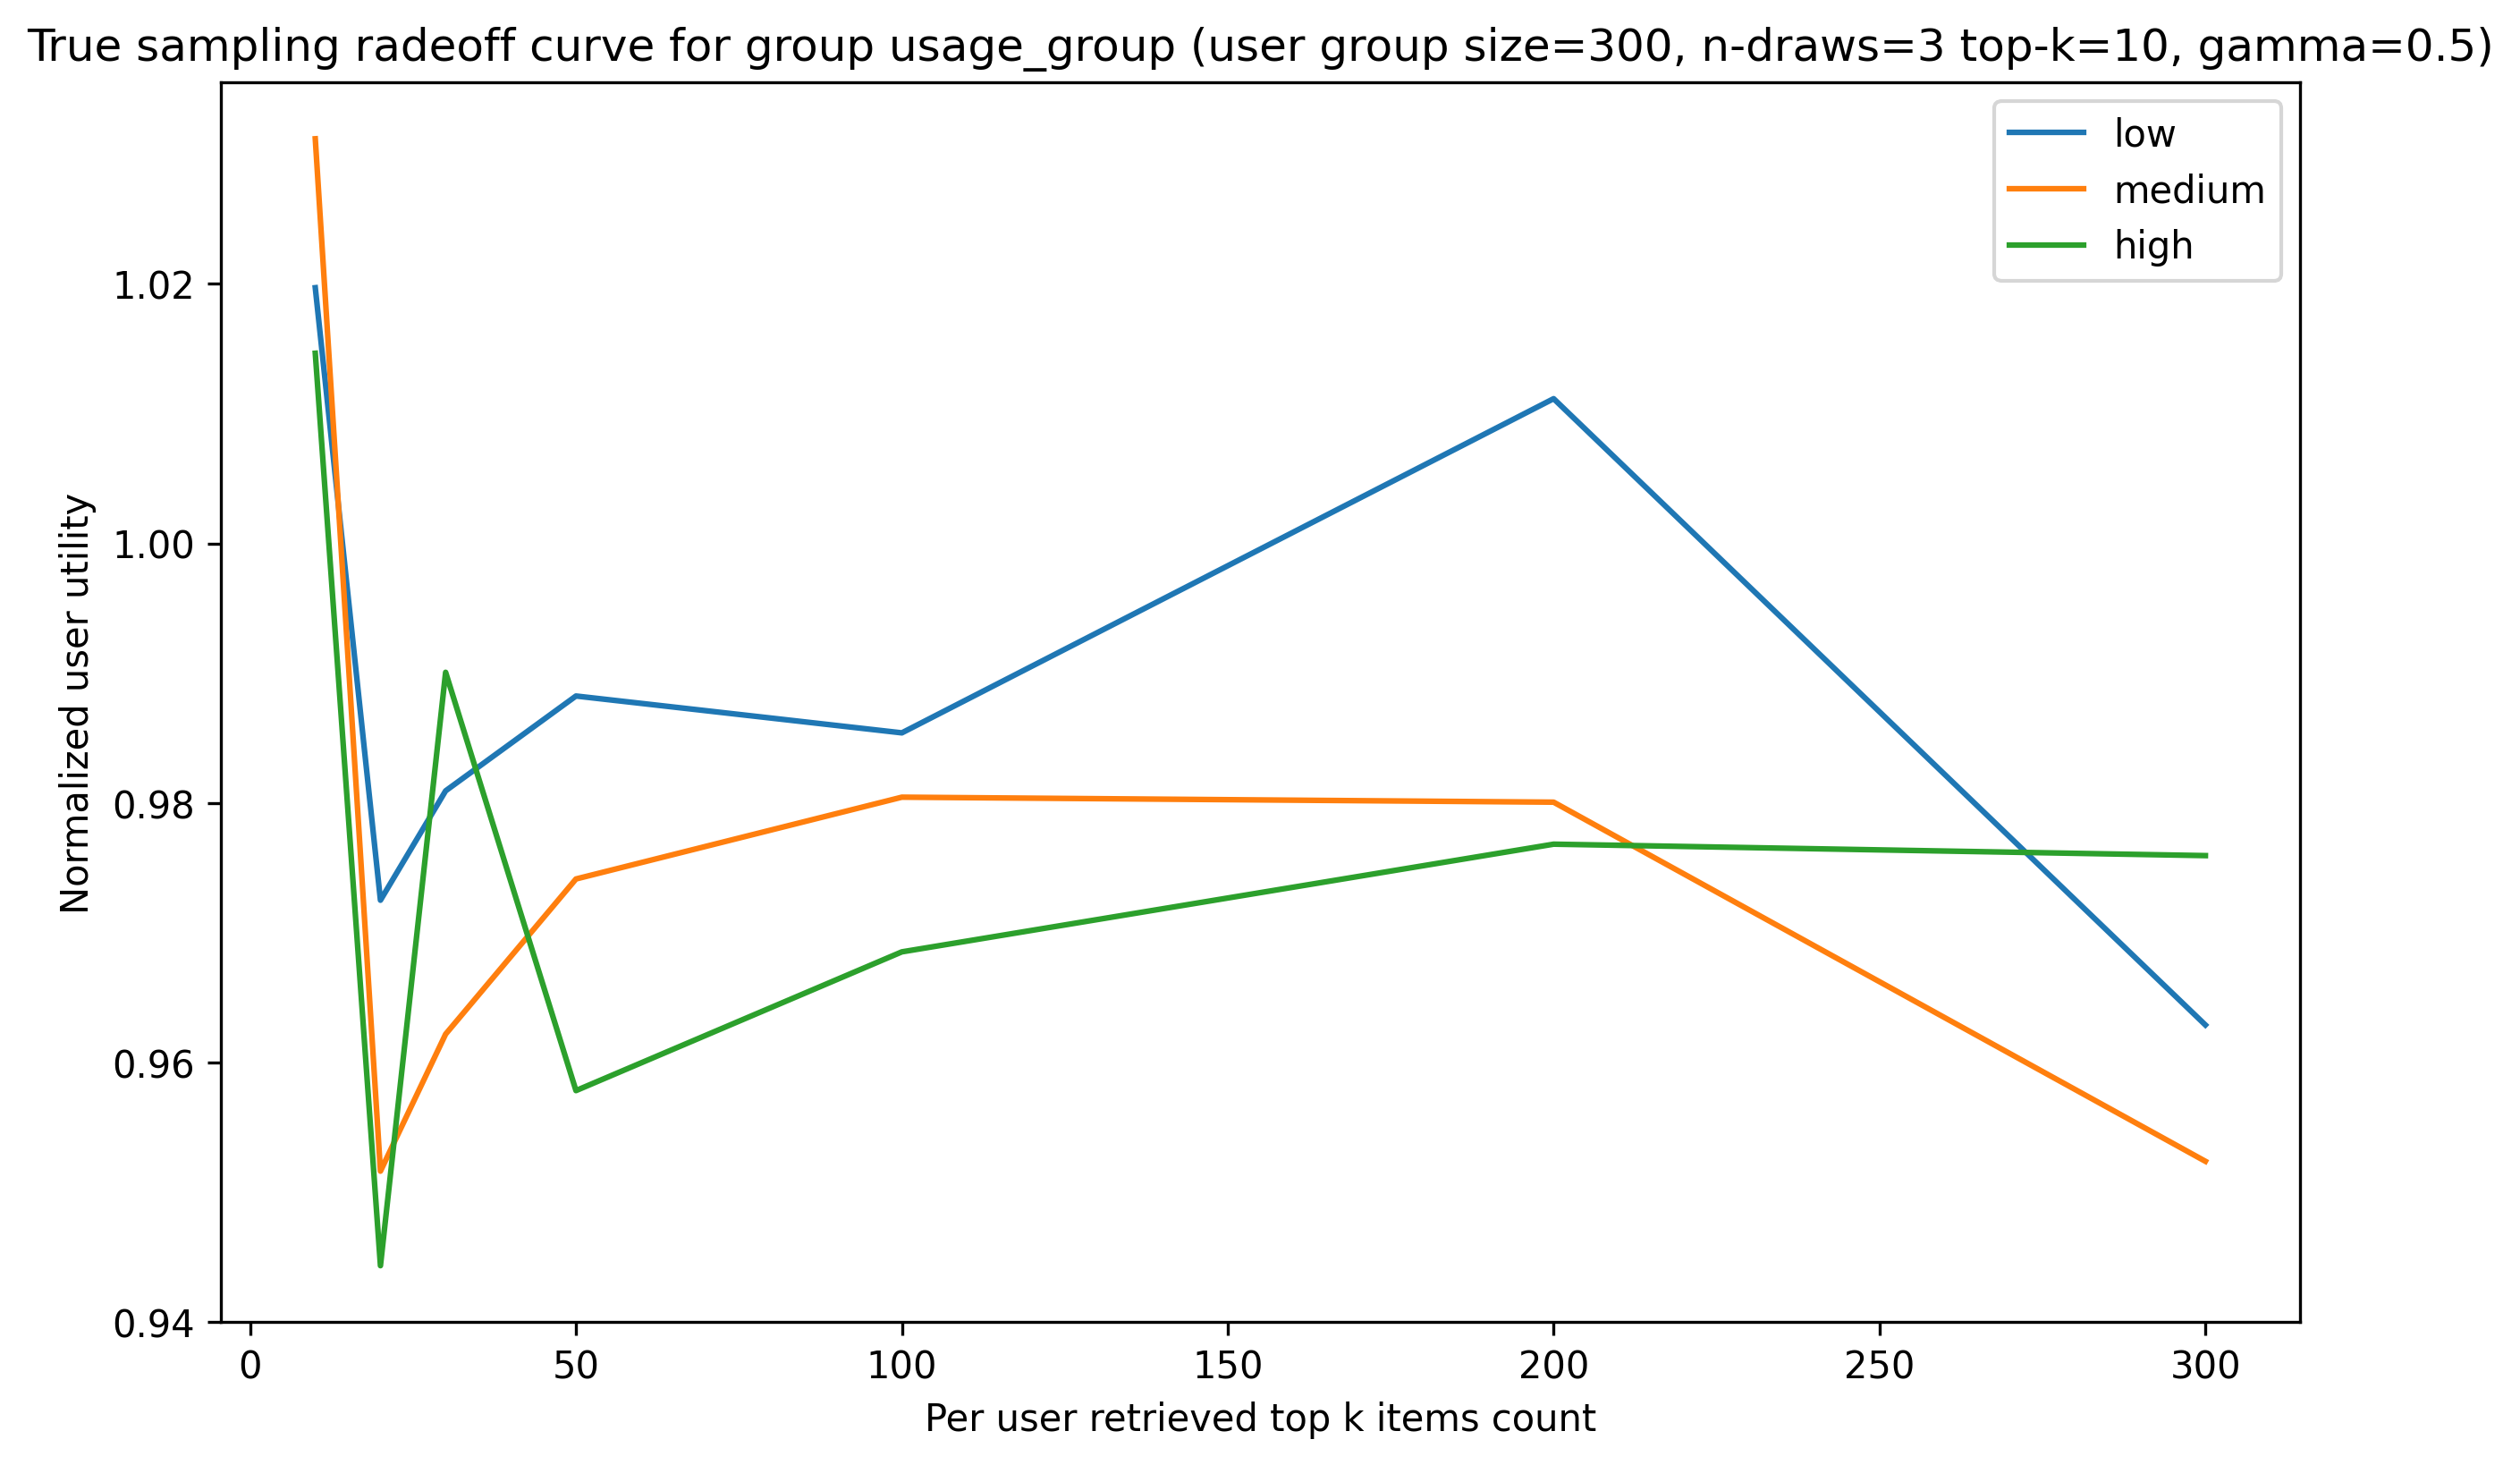

In [19]:
for group_name in ["top_genre", "usage_group"]:
    results = defaultdict(dict)
    items_size_ls = [10, 20, 30, 50, 100, 200, 300]
    for items_size in items_size_ls:
        gamma_points = [0.5]
        n_runs = 3
        user_size = 300
        top_k = 10

        all_empirical_pairs, users_ids, u_utils = get_curves_user_groups(u_rel_matrx, user_size, items_size, n_runs, gamma_points, top_k, user_groups, group_name, naive_sampling=False)

        group_utils_mean = defaultdict(list)
        for draw in range(n_runs):
            group_users = defaultdict(list)
            for row in user_groups:
                user_id = row["user_id"]
                if user_id in users_ids[draw]:
                    group_users[row[group_name]].append(users_ids[draw].index(user_id))

            for group, users in group_users.items():
                group_utils_mean[group].append(np.take(u_utils[draw][0], users).mean())

        for group, utils in group_utils_mean.items():
            results[group][items_size] = {"mean": np.mean(utils), "std": np.std(utils)}

    plt.figure(figsize=(10,6), dpi=300)
    for group, data in results.items():
        plt.plot(items_size_ls, [i["mean"] for i in data.values()], label=group)


    plt.ylabel('Normalized user utility')
    plt.title(f"True sampling radeoff curve for group {group_name} (user group size={user_size}, n-draws={n_runs} top-k={top_k}, gamma={gamma_points[0]})")
    plt.xlabel(r'Per user retrieved top k items count')
    #plt.plot(items_size_ls, all_empirical_pairs[:, :, 1].mean(axis=0), color="black", label="Mean minimal user utility across groups", linestyle="--")
    plt.legend()
    plt.savefig(f"./media7/ts_tradeoff_curve_group_{group_name}_user_size_{user_size}_n_draws_{n_runs}_top_k_{top_k}.png")

In [ ]:
GROUP_NAME = "top_genre"

gamma_points = 10
n_runs = 5
user_size = 300
items_size = 100
top_k = 1

all_empirical_pairs, users_ids, u_utils = get_curves_user_groups(u_rel_matrx, user_size, items_size, n_runs, gamma_points, top_k, user_groups, GROUP_NAME)

results = defaultdict(dict)
gammas = all_empirical_pairs[0,:,0]

for gamma in range(gamma_points):
    group_utils_mean = defaultdict(list)
    for draw in range(n_runs):
        group_users = defaultdict(list)
        for row in user_groups:
            user_id = row["user_id"]
            if user_id in users_ids[draw]:
                group_users[row[GROUP_NAME]].append(users_ids[draw].index(user_id))

        for group, users in group_users.items():
            group_utils_mean[group].append(np.take(u_utils[draw][gamma], users).mean())

    for group, utils in group_utils_mean.items():
        results[group][gamma] = {"mean": np.mean(utils), "std": np.std(utils)}



100%|██████████| 5/5 [2:48:22<00:00, 2020.45s/it]


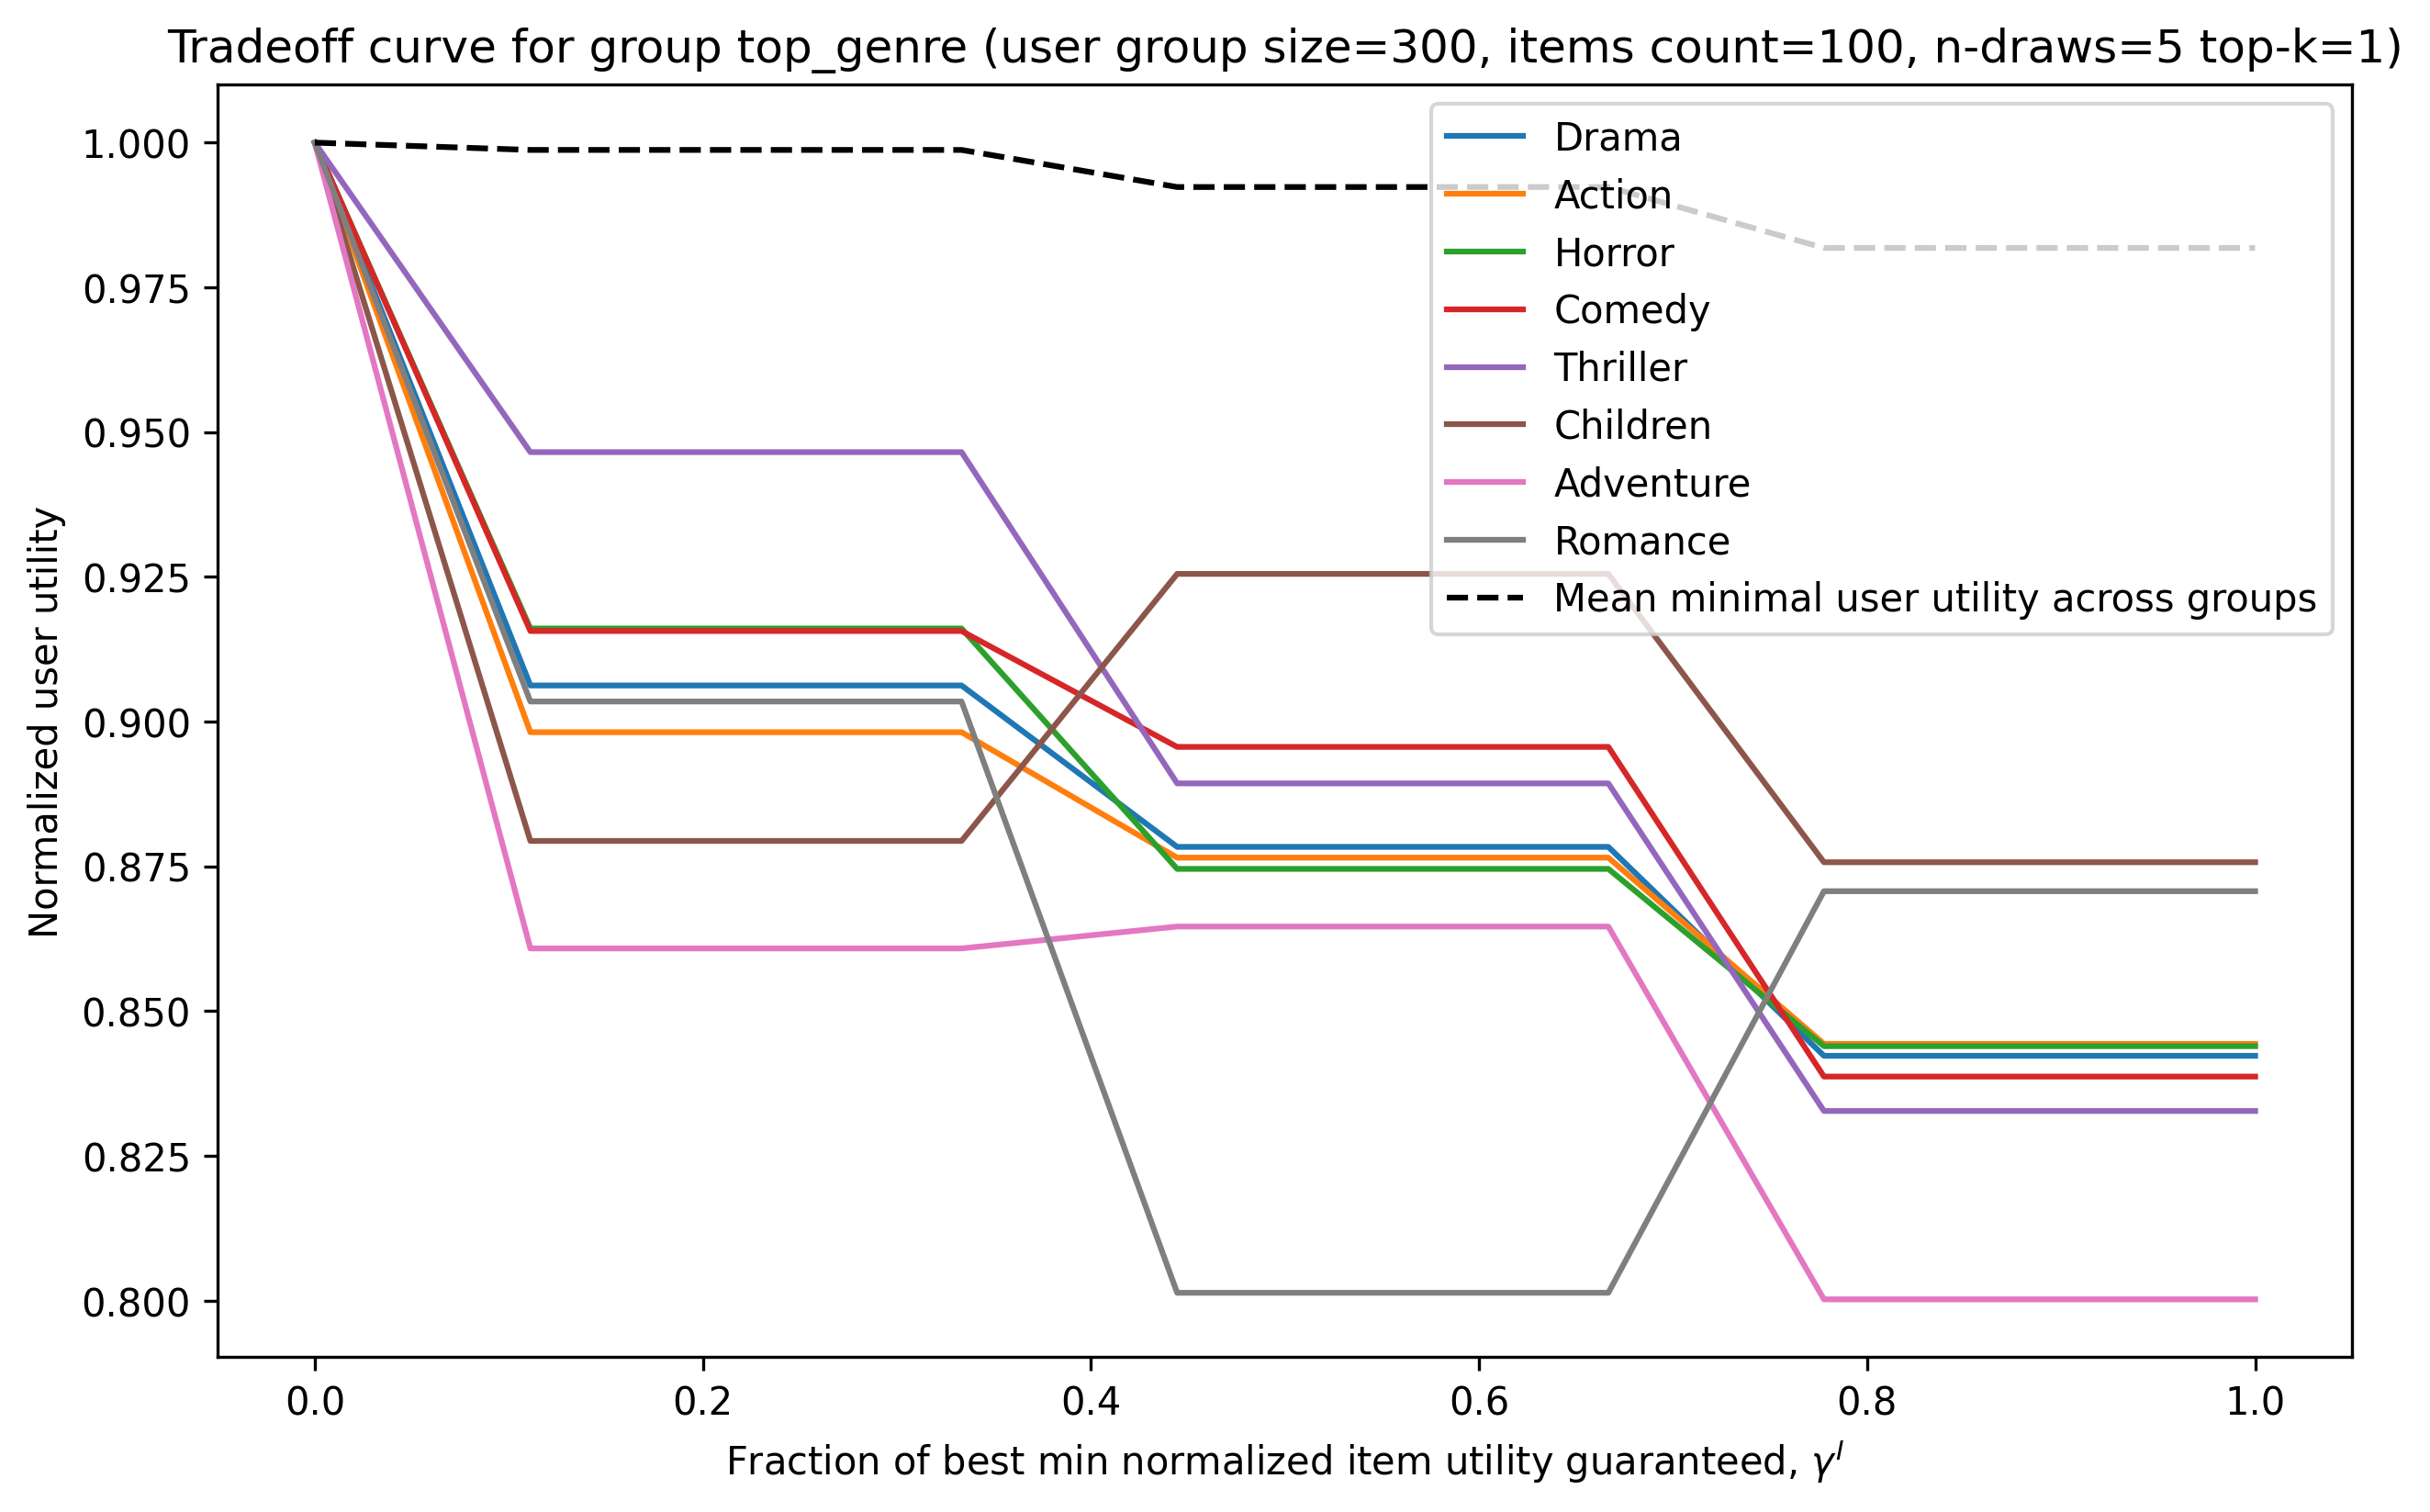

In [ ]:
plt.figure(figsize=(10,6), dpi=300)
for group, data in results.items():
    plt.plot(gammas, [i["mean"] for i in data.values()], label=group)
    plt.fill_between(gammas, [i["mean"] - 2*i["std"] / np.sqrt(n_runs) for i in data.values()], [i["mean"] + 2*i["std"] / np.sqrt(n_runs) for i in data.values()], alpha=0.2)


plt.ylabel('Normalized user utility')
plt.title(f"Tradeoff curve for group {GROUP_NAME} (user group size={user_size}, items count={items_size}, n-draws={n_runs} top-k={top_k})")
plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
plt.plot(gammas, all_empirical_pairs[:, :, 1].mean(axis=0), color="black", label="Mean minimal user utility across groups", linestyle="--")
plt.legend()
plt.savefig(f"./media4/tradeoff_curve_group_{GROUP_NAME}_user_size_{user_size}_items_{items_size}_n_draws_{n_runs}_top_k_{top_k}.png")

In [17]:
def get_user_curve(rel_matrix: np.ndarray, k_rec_list: list[int], delta: float, gamma: float) -> list[tuple[float, float]]:
    # First, compute u* for the unconstrained problem

    pairs = []
    u_utils = []
    for k_rec in k_rec_list:
        print(f"Computing for k={k_rec}")
        u_star = best_unconstrained(rel_matrix, k_rec).value

        # Now, do the actual convex optimization
        item_min_max = constrained_maxmin_item_given_user(rel_matrix, k_rec, delta, u_star).value
        user_min_max = constrained_maxmin_user_given_item(rel_matrix, k_rec, delta, 0, u_star)
        user_min_max_val = user_min_max.value
        user_min_max_val_user_level = (user_min_max.variables()[0].value * rel_matrix).sum(axis=1)

        v_user_result = constrained_maxmin_user_given_item(
            rel_matrix, k_rec, delta, gamma * item_min_max, u_star
        )
        u_utils.append((rel_matrix * v_user_result.variables()[0].value).sum(axis=1) / user_min_max_val_user_level)
        pair = (gamma, v_user_result.value / user_min_max_val)
        pairs.append(pair)

    return pairs, u_utils


def get_curves_user_groups(rel_matrix: np.ndarray, u_sample: int, i_sample: int, n_runs: int, gamma: float, k_rec_list: list[int], groups_map: list[dict[str, int]], group_name: str):
    all_empirical_pairs = []
    users_ids = []
    u_utils = []
    for _ in tqdm(range(n_runs)):
        rel_matrix_sampled, _users_ids = sample_users_from_groups(u_sample, i_sample, groups_map, group_name, rel_matrix)
        users_ids.append(_users_ids)

        pairs, _u_utils = get_user_curve(rel_matrix_sampled, k_rec_list, 1, gamma)
        u_utils.append(_u_utils)
        all_empirical_pairs.append(pairs)

    return np.array(all_empirical_pairs), users_ids, u_utils


gamma_points = 10
n_runs = 5
user_size = 300
items_size = 100
top_k = 1

In [20]:
import pickle

gamma = 1

res_genre = get_curves_user_groups(u_rel_matrx, user_size, items_size, 3, gamma, [round(i) for i in np.logspace(0, 2, 10)], user_groups, "top_genre")
with open(f"./results/res_genre_{gamma}.pkl", "wb") as f:
    pickle.dump(res_genre, f)

res_usage = get_curves_user_groups(u_rel_matrx, user_size, items_size, 3, gamma, [round(i) for i in np.logspace(0, 2, 10)], user_groups, "usage_group")

with open(f"./results/res_usage_{gamma}.pkl", "wb") as f:
    pickle.dump(res_usage, f)

  0%|          | 0/3 [00:00<?, ?it/s]

Computing for k=1
Computing for k=2
Computing for k=3
Computing for k=5
Computing for k=8
Computing for k=13
Computing for k=22
Computing for k=36
Computing for k=60
Computing for k=100


 33%|███▎      | 1/3 [05:25<10:51, 325.94s/it]

Computing for k=1
Computing for k=2
Computing for k=3
Computing for k=5
Computing for k=8
Computing for k=13
Computing for k=22
Computing for k=36
Computing for k=60
Computing for k=100


 67%|██████▋   | 2/3 [07:01<03:10, 190.41s/it]

Computing for k=1
Computing for k=2
Computing for k=3
Computing for k=5
Computing for k=8
Computing for k=13
Computing for k=22
Computing for k=36
Computing for k=60
Computing for k=100


  0%|          | 0/3 [00:00<?, ?it/s]

Computing for k=1
Computing for k=2
Computing for k=3
Computing for k=5
Computing for k=8
Computing for k=13
Computing for k=22
Computing for k=36
Computing for k=60
Computing for k=100


 33%|███▎      | 1/3 [01:16<02:33, 76.61s/it]

Computing for k=1
Computing for k=2
Computing for k=3
Computing for k=5
Computing for k=8
Computing for k=13
Computing for k=22
Computing for k=36
Computing for k=60
Computing for k=100


 67%|██████▋   | 2/3 [05:55<03:15, 195.55s/it]

Computing for k=1
Computing for k=2
Computing for k=3
Computing for k=5
Computing for k=8
Computing for k=13
Computing for k=22
Computing for k=36
Computing for k=60
Computing for k=100


100%|██████████| 3/3 [07:53<00:00, 157.82s/it]


In [41]:
# list all files in ./results
import os

files = os.listdir("./results")
data = []
for file in files:
    _metadata = {}
    _metadata["group"] = "top_genre" if "genre" in file else "usage_group"
    _metadata["gamma"] = file.split("_")[-1].split(".pkl")[0]
    with open(f"./results/{file}", "rb") as f:
        res = pickle.load(f)
        data.append((res, _metadata))

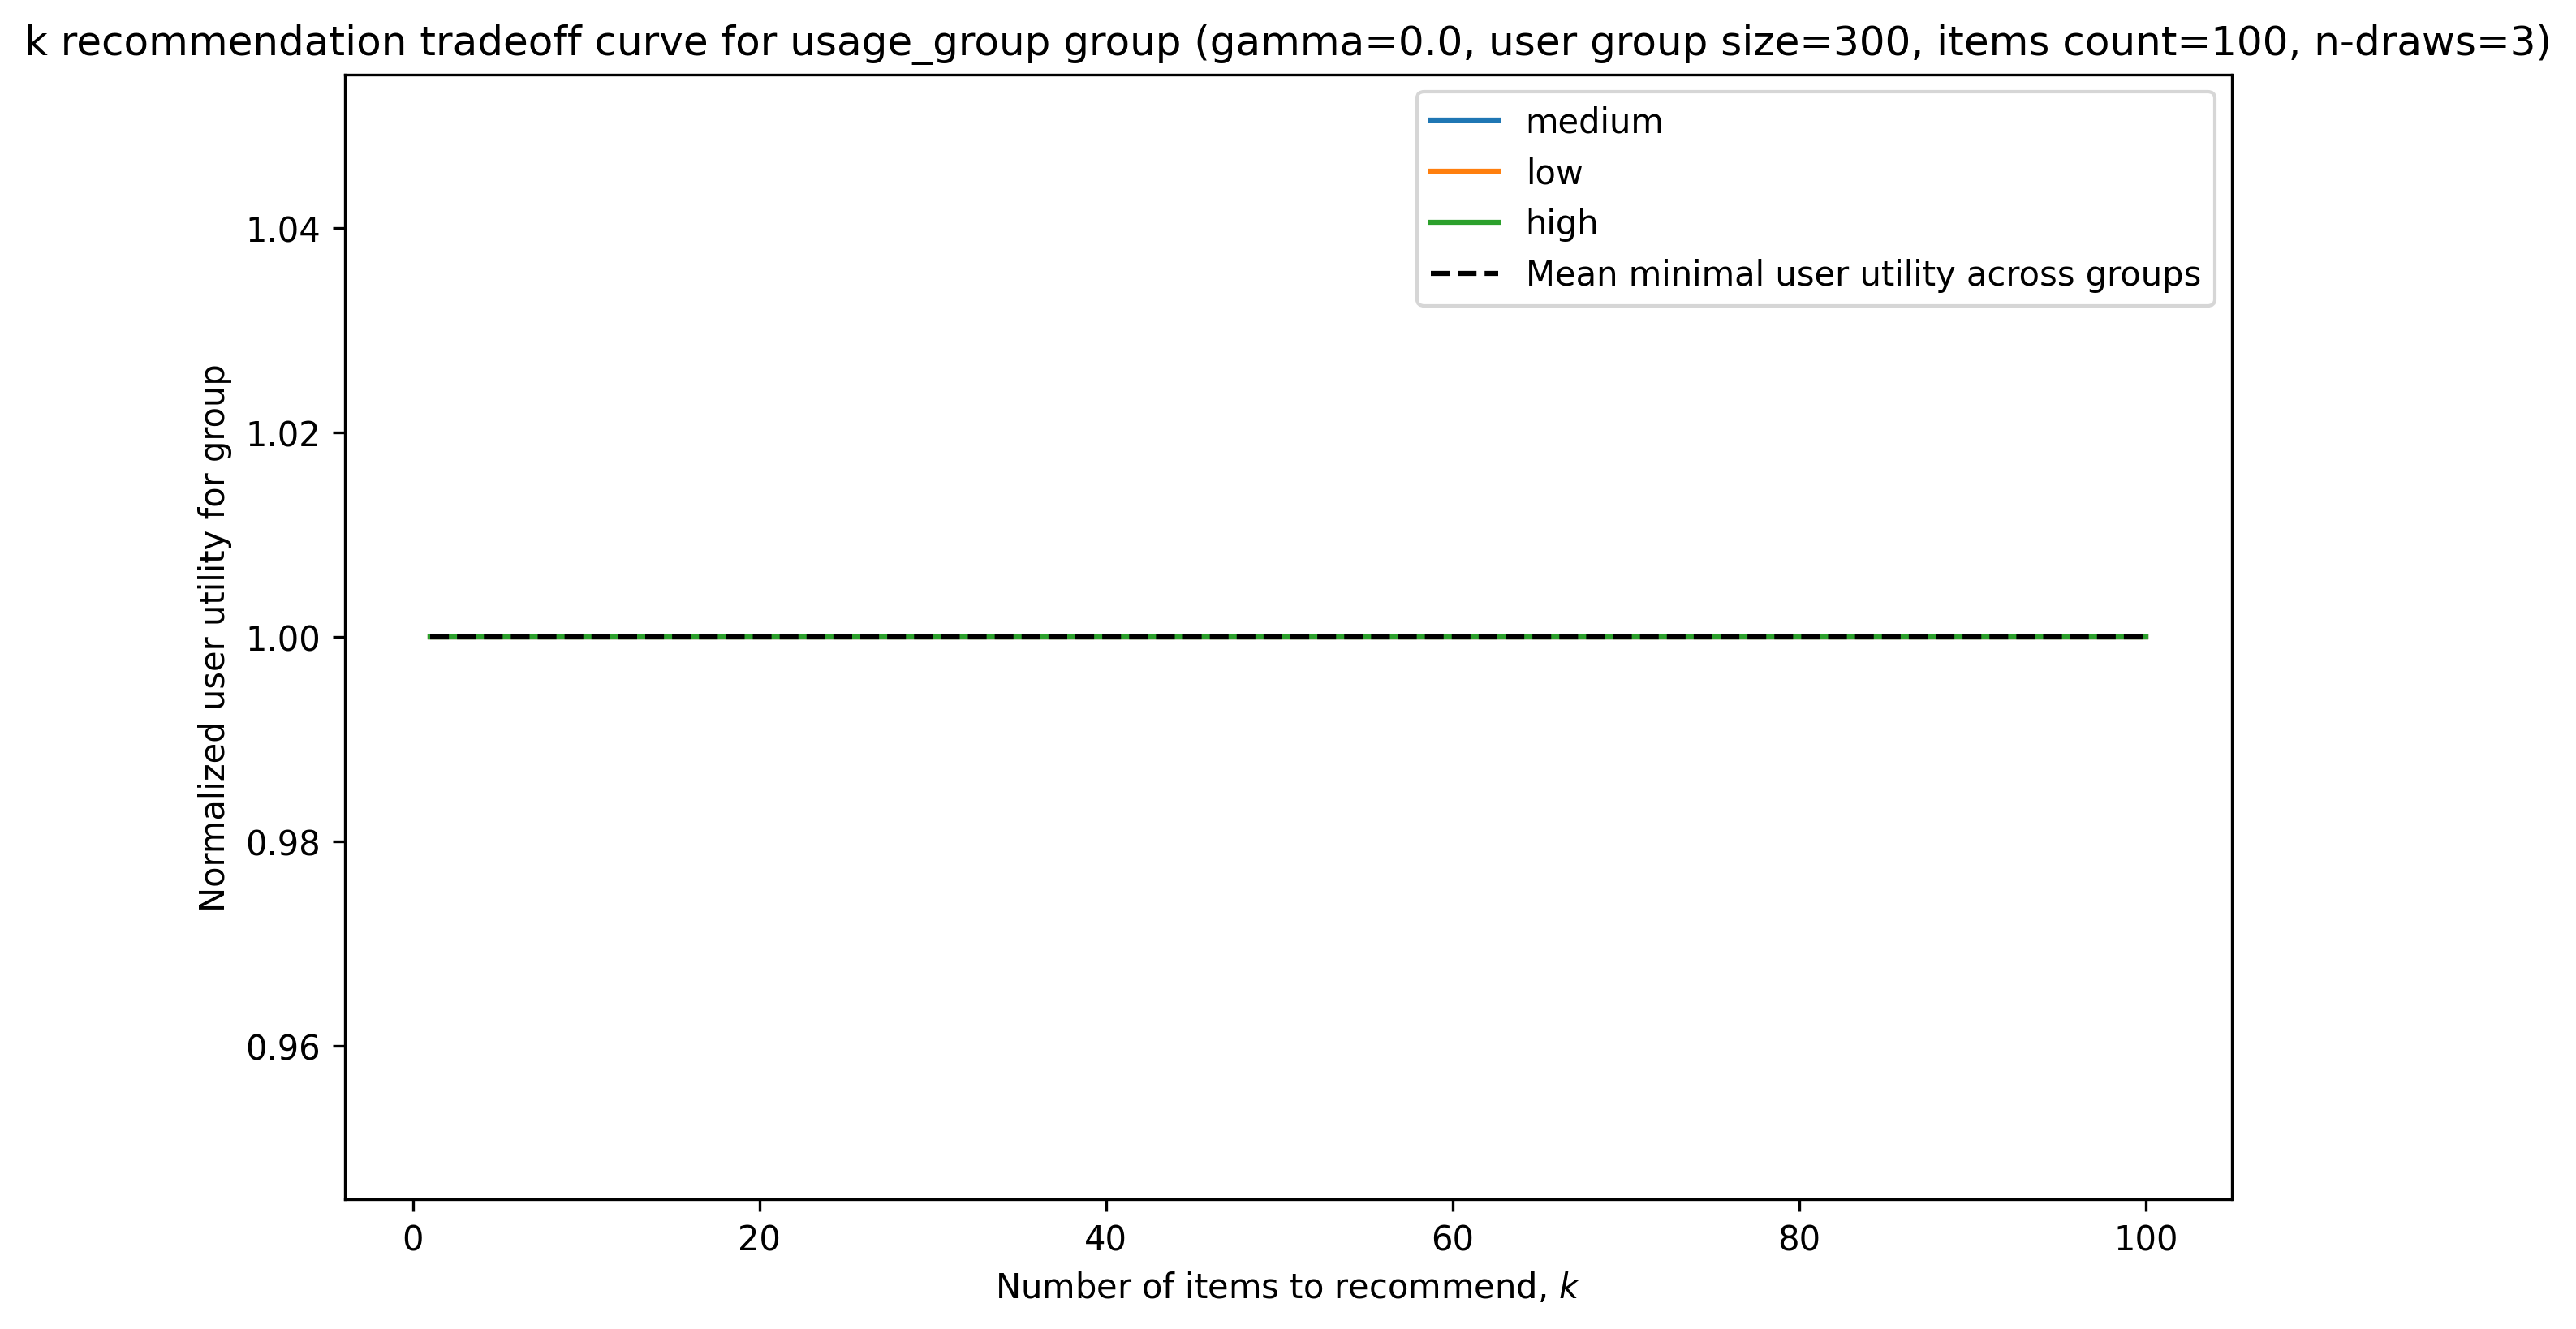

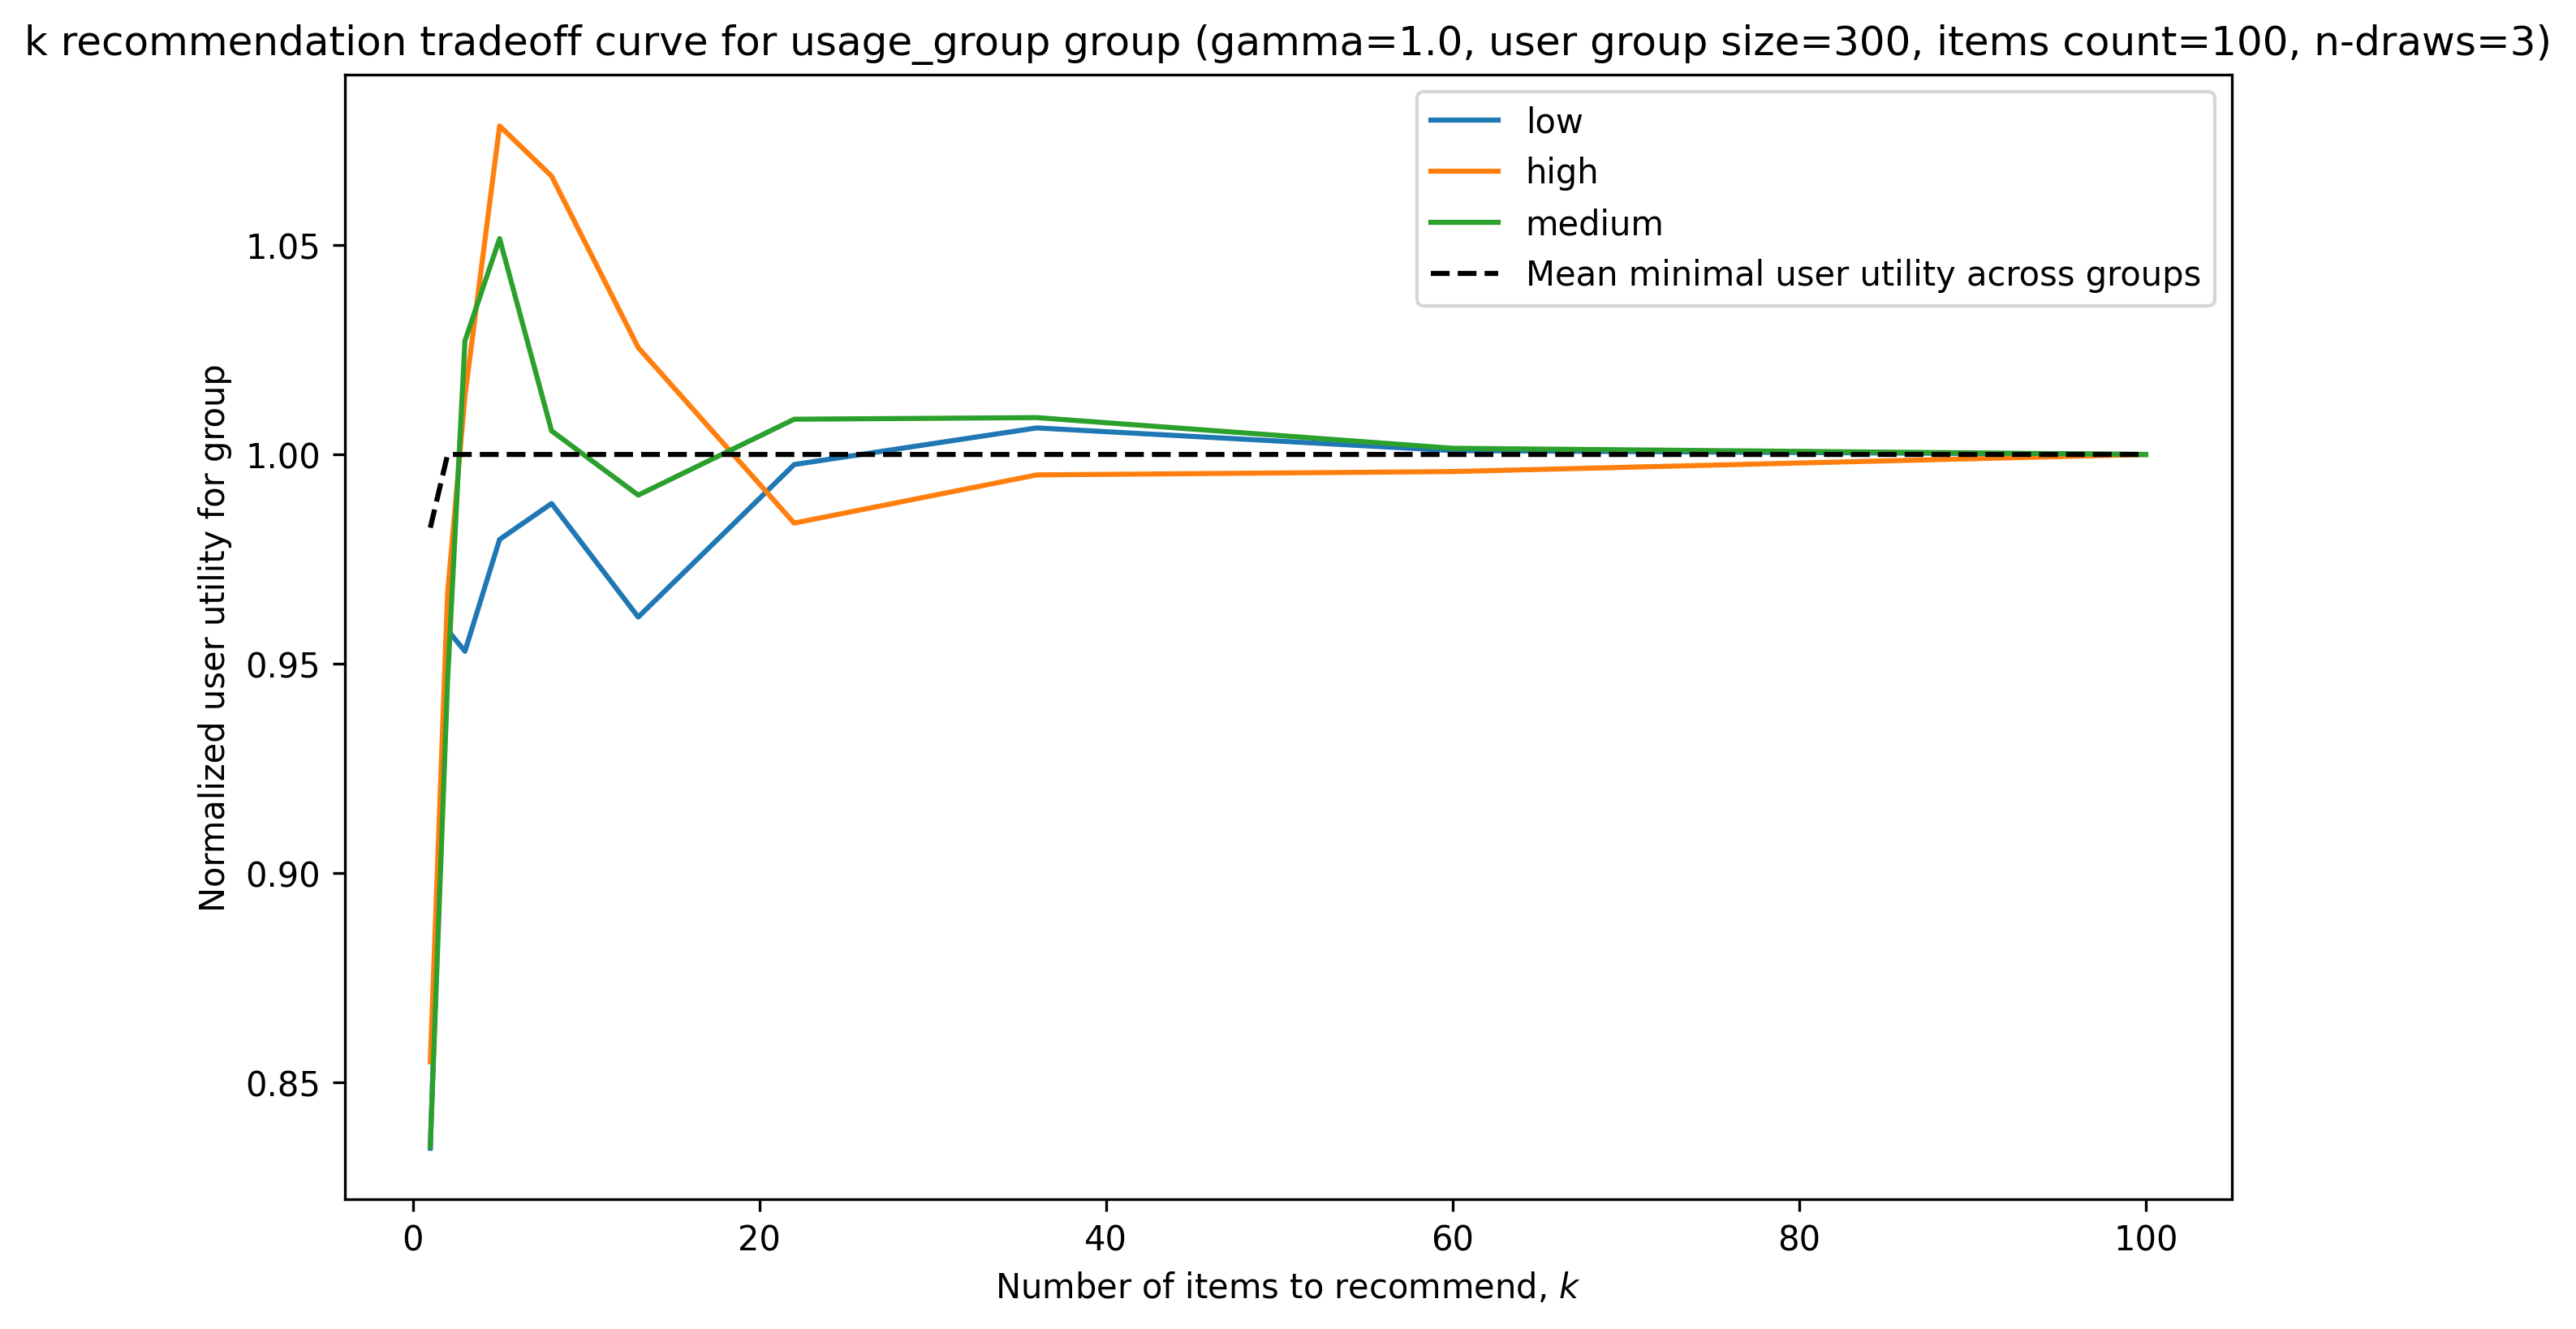

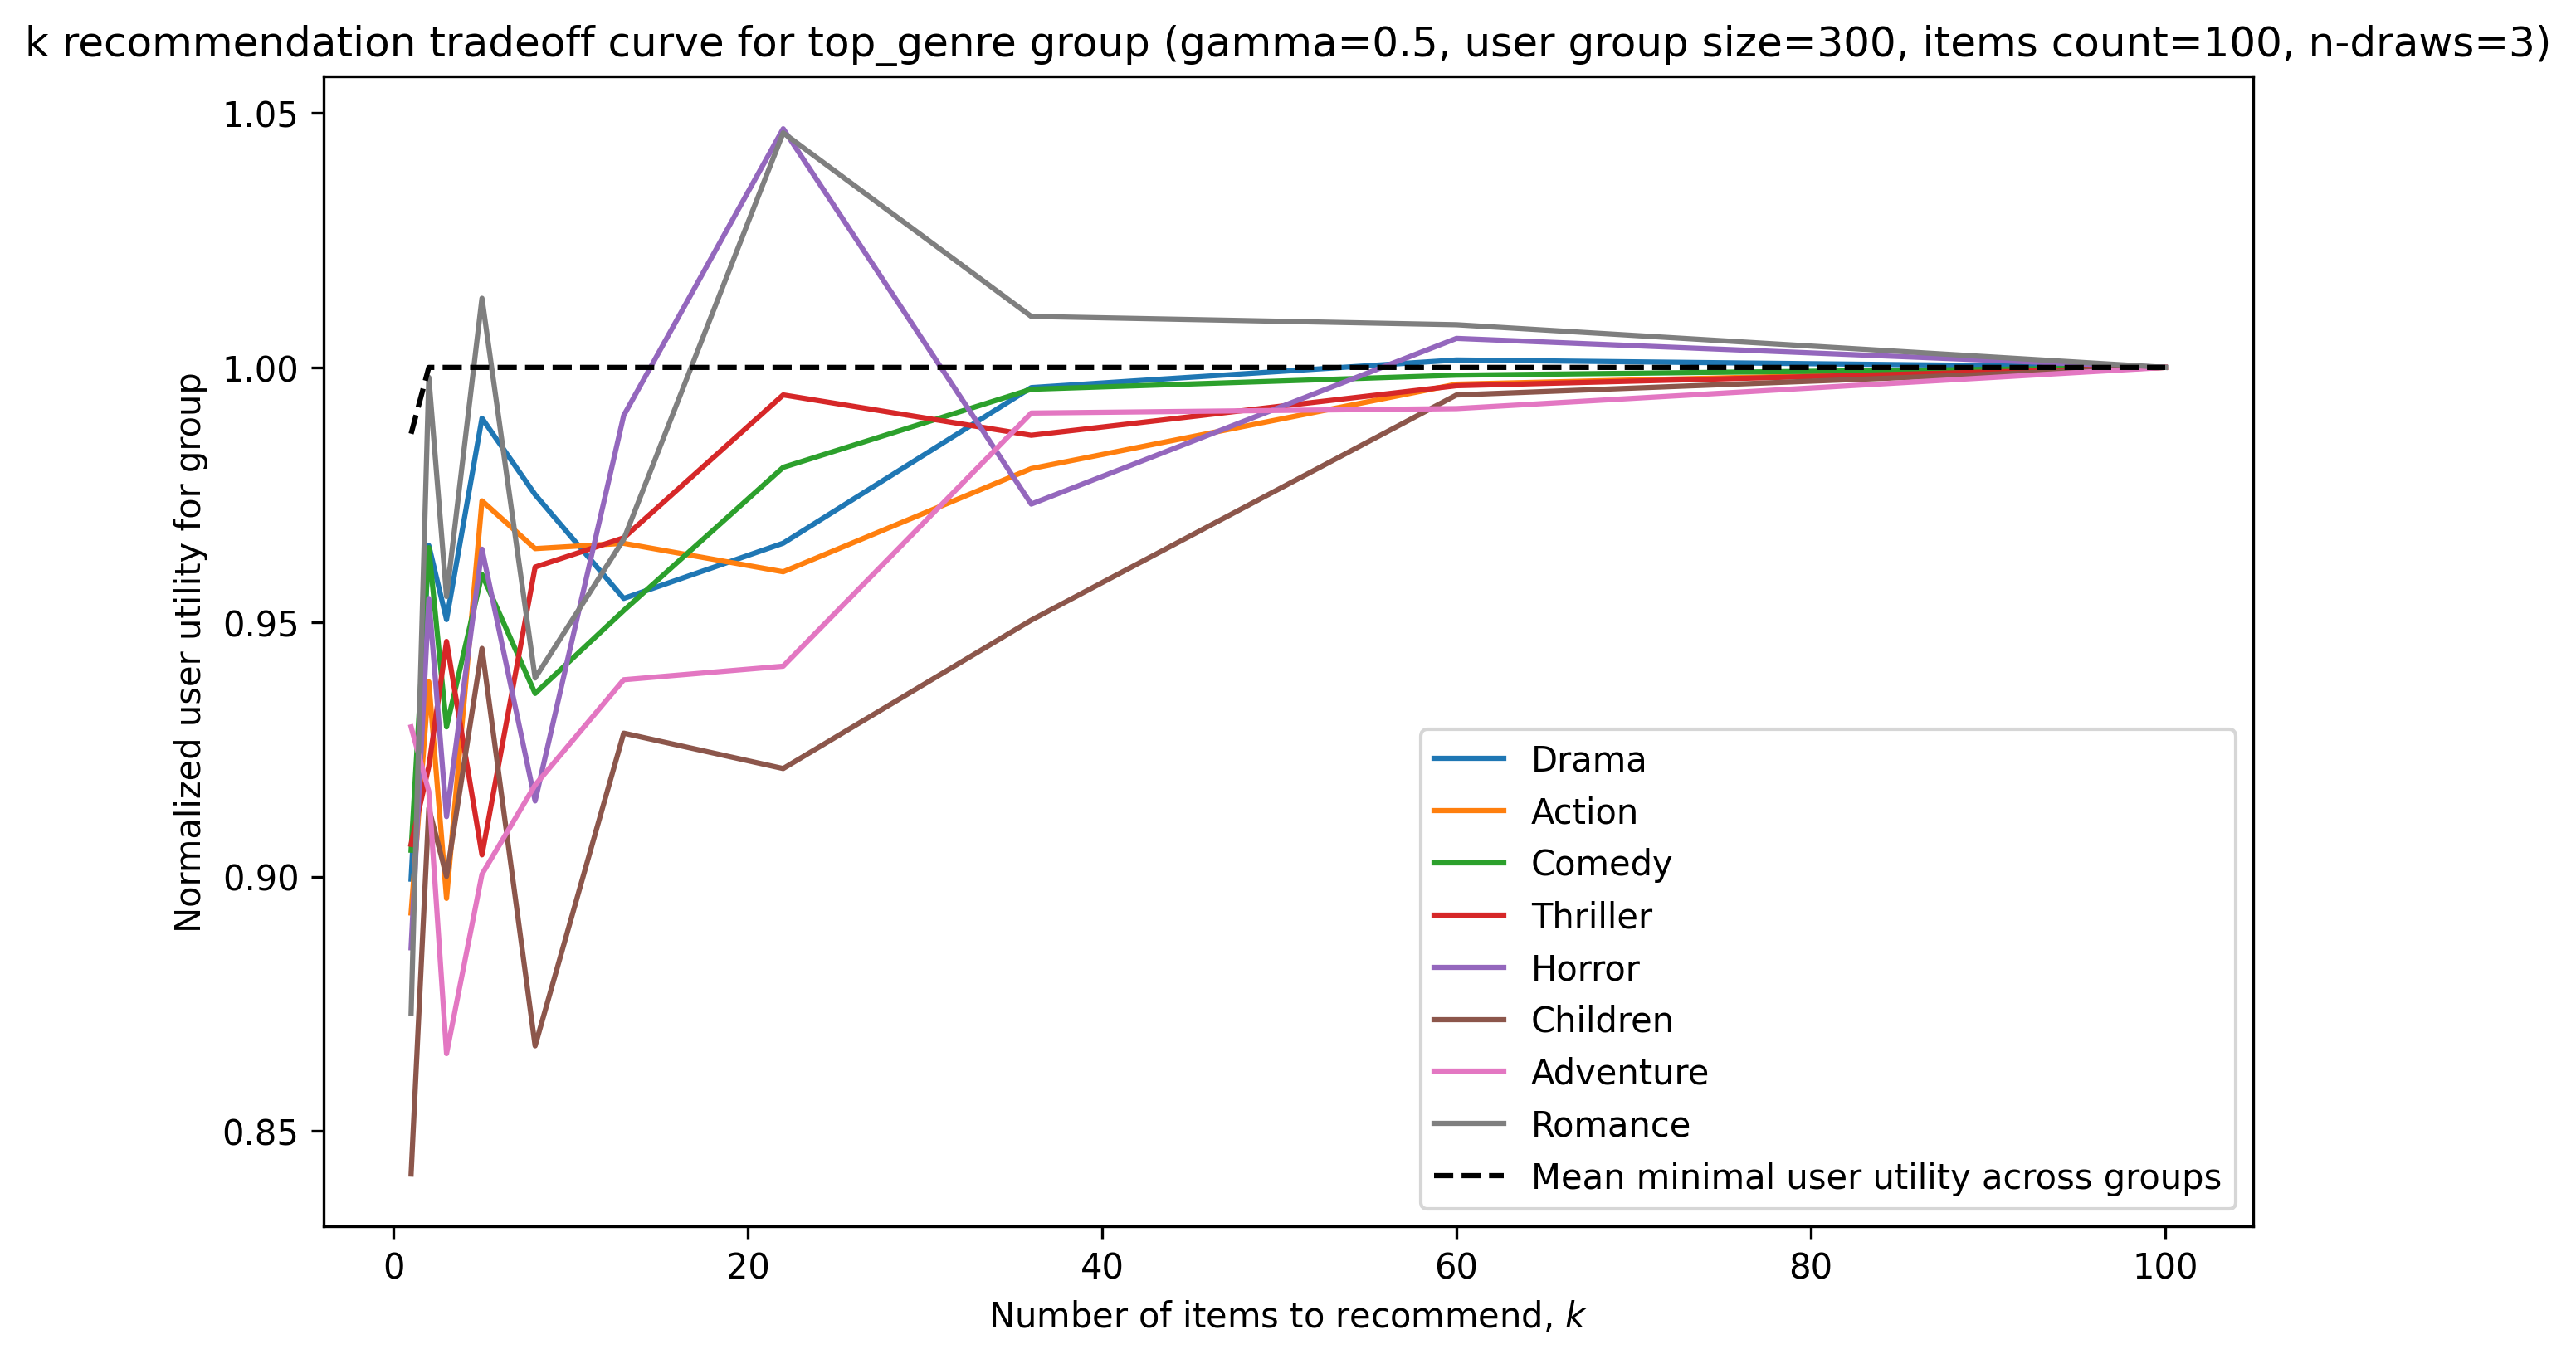

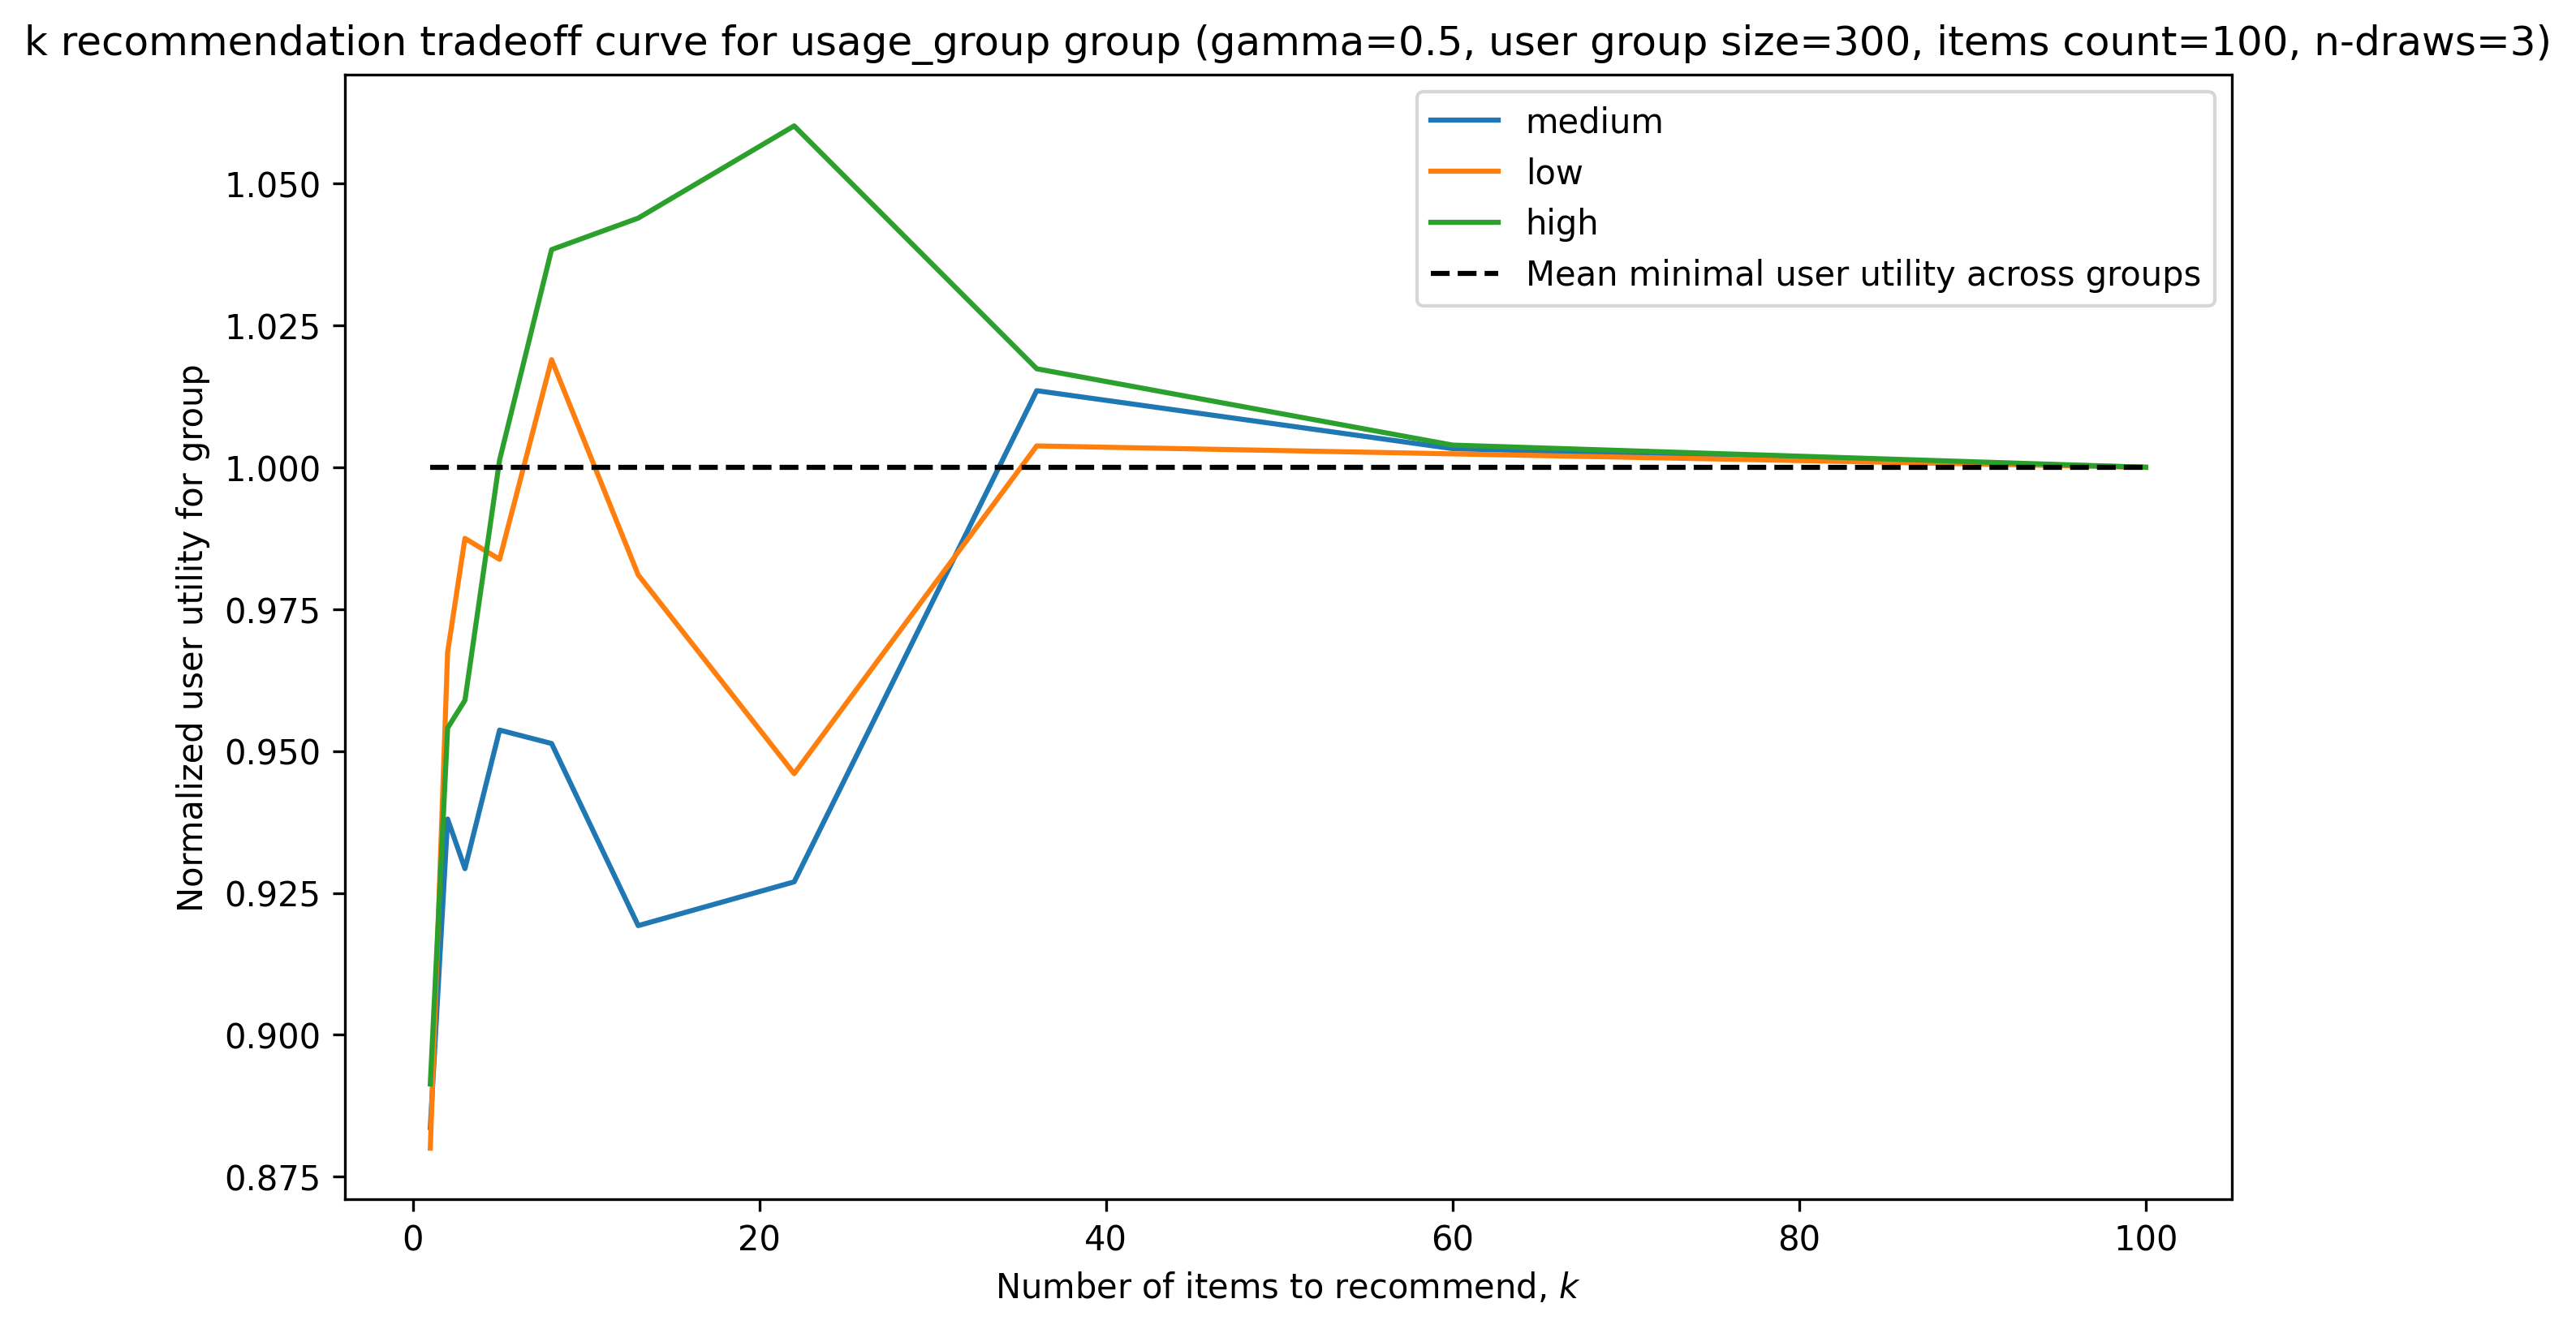

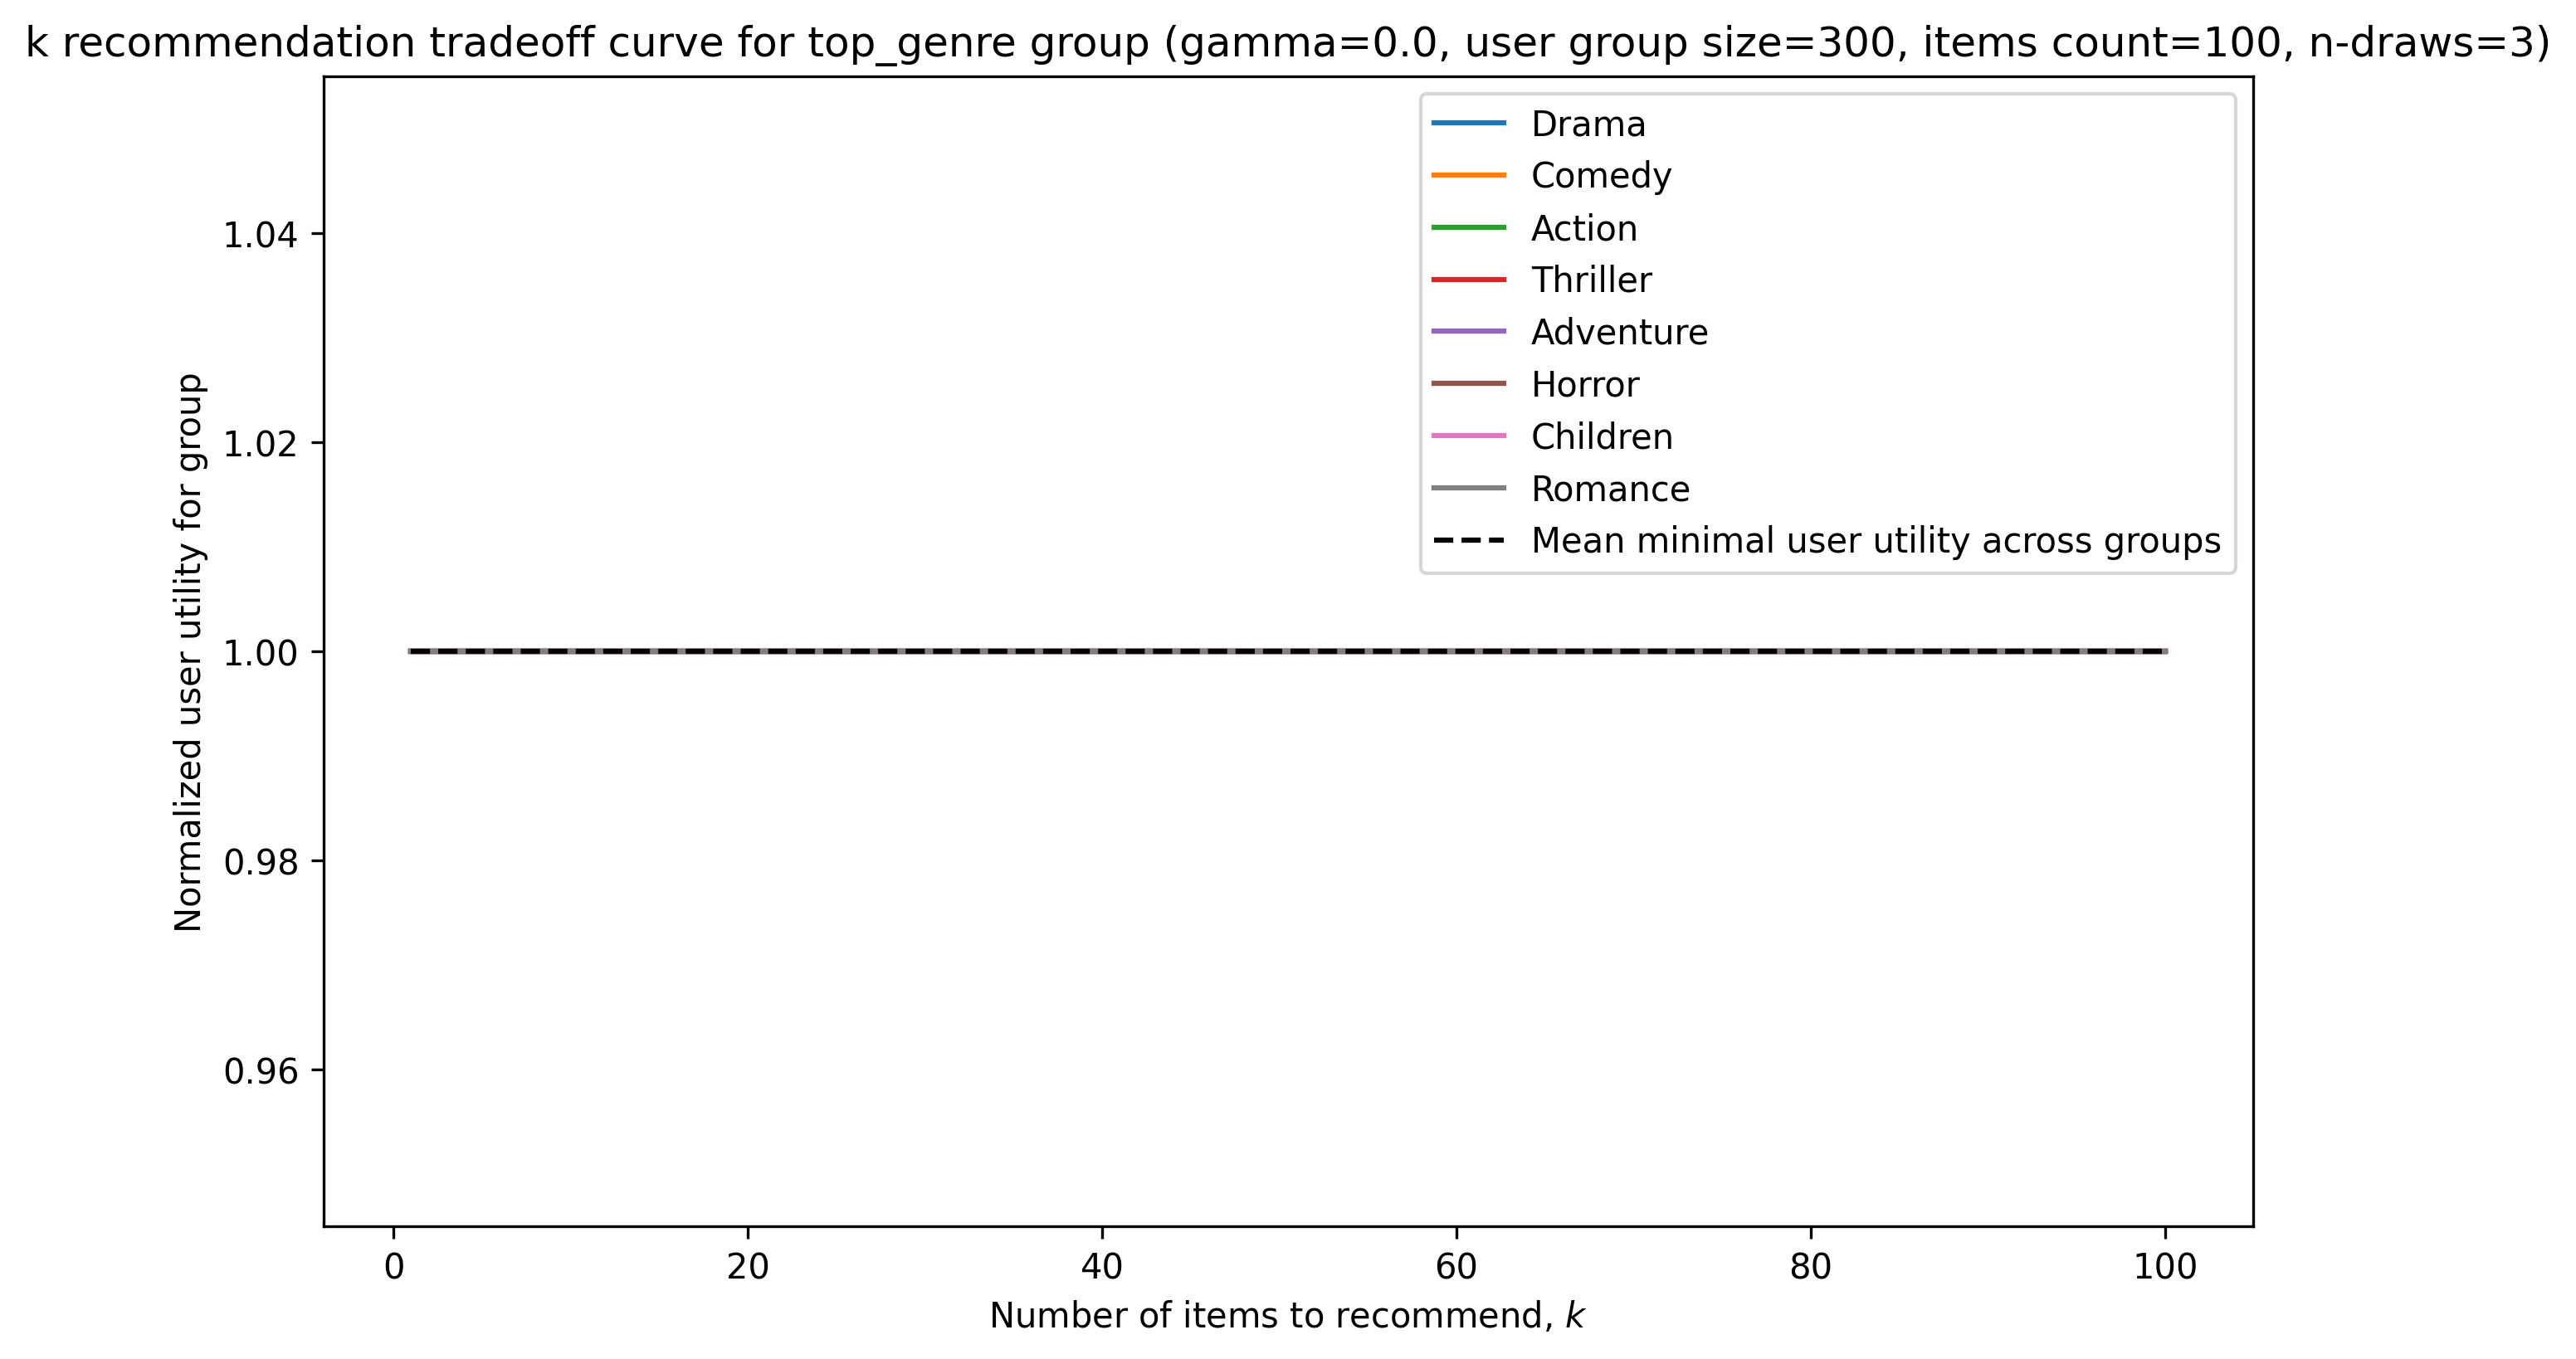

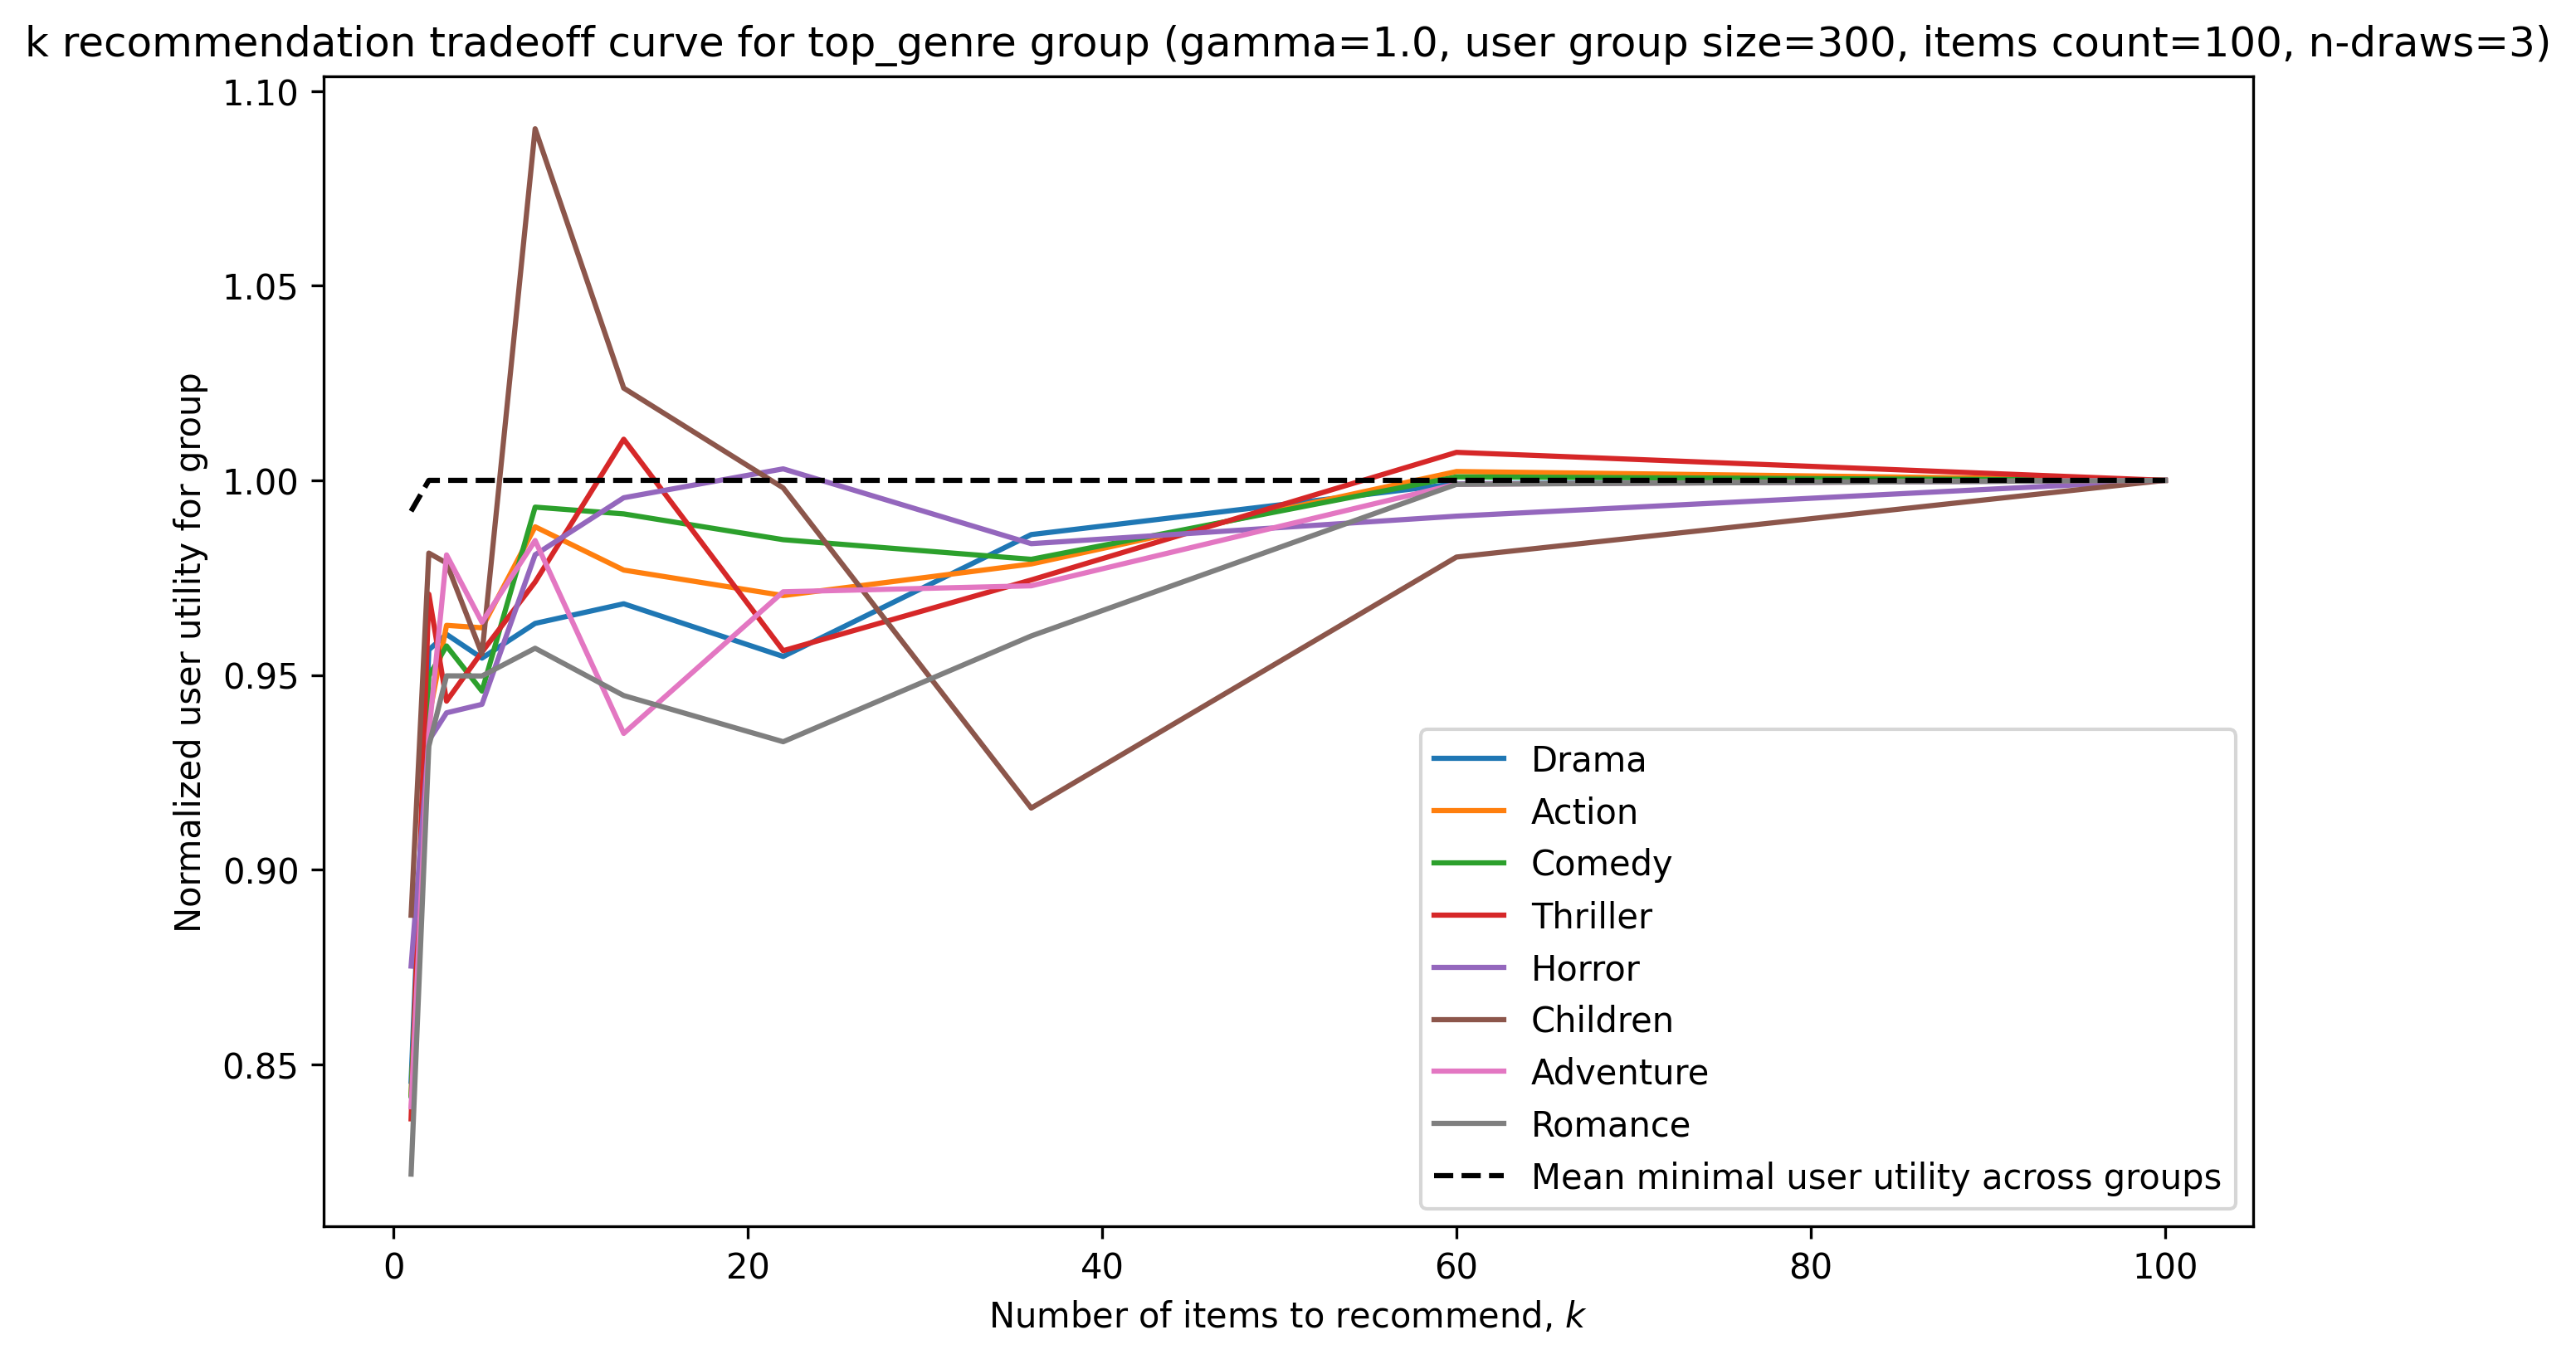

In [42]:
n_runs = 3
user_size = 300
items_size = 100
top_ks = [round(i) for i in np.logspace(0, 2, 10)]

for entry in data:
    all_empirical_pairs, users_ids, u_utils = entry[0]
    GROUP_NAME = entry[1]["group"]
    gamma = entry[1]["gamma"]

    results = defaultdict(dict)
    for topk_idx, topk in enumerate(top_ks):
        group_utils_mean = defaultdict(list)
        for draw in range(n_runs):
            group_users = defaultdict(list)
            for row in user_groups:
                user_id = row["user_id"]
                if user_id in users_ids[draw]:
                    group_users[row[GROUP_NAME]].append(users_ids[draw].index(user_id))

            for group, users in group_users.items():
                group_utils_mean[group].append(np.take(u_utils[draw][topk_idx], users).mean())

        for group, utils in group_utils_mean.items():
            results[group][topk] = {"mean": np.mean(utils), "std": np.std(utils)}

    plt.figure(figsize=(10,6), dpi=300)
    for group, data in results.items():
        plt.plot(top_ks, [i["mean"] for i in data.values()], label=group)
        #plt.fill_between(gammas, [i["mean"] - 2*i["std"] / np.sqrt(n_runs) for i in data.values()], [i["mean"] + 2*i["std"] / np.sqrt(n_runs) for i in data.values()], alpha=0.2)


    plt.ylabel('Normalized user utility for group')
    plt.title(f"k recommendation tradeoff curve for {GROUP_NAME} group (gamma={float(gamma)}, user group size={user_size}, items count={items_size}, n-draws={n_runs})")
    plt.xlabel(r'Number of items to recommend, $k$')
    plt.plot(top_ks, all_empirical_pairs[:, :, 1].mean(axis=0), color="black", label="Mean minimal user utility across groups", linestyle="--")
    plt.legend()
    plt.savefig(f"./media5/k-rec_tradeoff_curve_group_{GROUP_NAME}_user_size_{user_size}_items_{items_size}_n_draws_{n_runs}_gamma_{gamma}.png")